In [1]:
!pip install langchain_community
!pip install faiss-gpu
!pip install faiss-cpu
!pip install huggingface-hub
!pip install rank_bm25
!pip install fuzzywuzzy
!pip install tiktoken
!pip install sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.1/434.1 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.1 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.52
    Uninstalling langchain-core-0.3.52:
      Successfully uninstalled langchain-core-0.3.52
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.23
    Uninstalling langchain-0.3.23:
      Successfully uninstalled langchain-0.3.23
ERROR: Could not find a version that satisfies the requirement faiss-gpu (from versions: none)
ERROR: No matching distribution found for faiss-gpu
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import pandas as pd
import numpy as np
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.schema import Document
import math
import re
from typing import Dict, List, Tuple, Any
from transformers import pipeline
from tqdm import tqdm

# Load and join data

In [3]:
df = pd.read_csv("/content/wine_data_final.csv") #change the path
df.shape

(6312, 26)

In [4]:
df.columns

Index(['title', 'id', 'review_1', 'review_2', 'review_3', 'review_4',
       'review_5', 'review_6', 'review_7', 'review_8', 'review_9', 'review_10',
       'country', 'description', 'designation', 'points', 'price', 'province',
       'region_1', 'region_2', 'taster_name', 'taster_twitter_handle',
       'variety', 'winery', 'vintage', 'wine_color'],
      dtype='object')

In [6]:
labeled = pd.read_csv('/content/llm_labeled.csv') #change the path
df = pd.merge(df, labeled, on='id', how='inner')
print(df.shape)

(6312, 34)


In [7]:
df["Flavor_Profile_Oak"] = (df["Flavor_Profile_Oak"].fillna(0).astype(int))

In [8]:
top_wines_journal = pd.read_csv('/content/top_wines_journal.csv') #change the path
top_wines_journal.head(1)

,id_dataset,top100_year,color,top100_rank,wine_type
0,2170223,2014,dessert,1,dessert


In [9]:
df = df.merge(top_wines_journal, how='left', left_on='id', right_on='id_dataset')
df = df.drop(columns = ['id_dataset'])

In [10]:
df['is_in journal'] = df['top100_year'].notna().astype(int)
df['is_top_red'] = ((df['color'] == 'red') & (df['top100_year'].notna())).astype(int)
df['is_top_white'] = ((df['color'] == 'white') & (df['top100_year'].notna())).astype(int)

In [11]:
df.columns

Index(['title', 'id', 'review_1', 'review_2', 'review_3', 'review_4',
       'review_5', 'review_6', 'review_7', 'review_8', 'review_9', 'review_10',
       'country', 'description', 'designation', 'points', 'price', 'province',
       'region_1', 'region_2', 'taster_name', 'taster_twitter_handle',
       'variety', 'winery', 'vintage', 'wine_color', 'Premium_Wines',
       'Value_Wines', 'Food_Pairing_Meat', 'Food_Pairing_Seafood',
       'Food_Pairing_Spicy', 'Food_Pairing_Dessert', 'Flavor_Profile_Spice',
       'Flavor_Profile_Oak', 'top100_year', 'color', 'top100_rank',
       'wine_type', 'is_in journal', 'is_top_red', 'is_top_white'],
      dtype='object')

In [27]:
all_review_cols = [col for col in df.columns if col.startswith("review_")]
review_cols = all_review_cols[:5]

def clean_text(text):
    return str(text).replace("\\n", " ").replace("\n", " ").replace("\r", " ").strip()

documents = []
meta_fields = ["price", "points", "province", "variety", "designation", "country", "region_1", "winery"]

for idx, row in df.iterrows():
    sections = []

    if "title" in df.columns and pd.notna(row["title"]):
        title_clean = clean_text(row["title"])
        sections.append(f"Title: {title_clean}")

    if "description" in df.columns and pd.notna(row["description"]):
        desc_clean = clean_text(row["description"])
        sections.append(f"Description: {desc_clean}")

    meta_parts = []
    for col in meta_fields:
        if col in df.columns and pd.notna(row[col]):
            meta_parts.append(f"{col.capitalize()}: {row[col]}")
    if "vintage" in df.columns and pd.notna(row["vintage"]):
        meta_parts.append(f"Vintage: {row['vintage']}")
    if "wine_color" in df.columns and pd.notna(row["wine_color"]):
        meta_parts.append(f"Wine Color: {row['wine_color']}")

    if meta_parts:
        metadata_section = ", ".join(meta_parts)
        sections.append(metadata_section)

    review_texts = []
    for col in review_cols:
        if pd.notna(row[col]):
            review_clean = clean_text(row[col])
            review_texts.append(review_clean)
    if review_texts:
        reviews_section = "Reviews:\n" + "\n".join(review_texts)
        sections.append(reviews_section)

    meta = {}
    for col in meta_fields + ["id"]:
        if col in df.columns:
            meta[col] = row[col]
    if "vintage" in df.columns:
        meta["vintage"] = row["vintage"]
    if "wine_color" in df.columns:
        meta["wine_color"] = row["wine_color"]

    if "id" in df.columns and pd.notna(row["id"]):
        meta["id"] = row["id"]
    else:
        meta["id"] = f"doc_{idx}"

    full_text = "\n".join(sections)

    doc = Document(page_content=full_text, metadata=meta)
    documents.append(doc)

print(f"Created {len(documents)} Document objects from the dataset.")

print("\nExample document:")
print(documents[0].page_content)

Created 6312 Document objects from the dataset.

Example document:
Title: Chateau Lafayette Reneau 2016 Pinot Noir Rosé (Finger Lakes)
Description: Ripe luscious black-cherry and berry notes lend heft to this bold concentrated rosé. It's just a shade off dry, but balances neatly, juxtaposing crisp acidity against lavish texture and a pleasantly clingy finish.
Price: 17.0, Points: 89, Province: New York, Variety: Rosé, Designation: Pinot Noir, Country: US, Region_1: Finger Lakes, Winery: Chateau Lafayette Reneau, Vintage: 2016, Wine Color: Rosé
Reviews:
('Aromas of strawberry, cherry, and red fruit.  Tastes of red fruit, tart cherry.  A bit sweet for me.  3.6-3.7', 3.5)
('A superb choice that brings a cooling effect to counter the intensity of spice.', 4.0)
('No wonder this one has won so many awards! Amazing!', 5.0)
('NY Rose / great chilled ', 5.0)
("So satisfying and affordable; it's a must-try for value seekers.", 3.7)


# System functions

In [13]:
import openai
def set_up_llm():
    os.environ['OPENAI_API_KEY'] = ''
    client = OpenAI()
    return client

def prompt_llm(client, prompt: str) -> str:
    response = client.chat.completions.create(
    model="gpt-4o-mini-2024-07-18",
    messages=[
        {"role": "user", "content": prompt}
    ]
    )
    return response.choices[0].message.content

In [14]:
import os
import ast
from openai import OpenAI
client = set_up_llm()

In [15]:
def extract_metadata(client, query) -> dict:
    prompt = f"""
You are a specialized data extraction assistant. Your task is to extract the metadata from the user's input query and return a dictionary containing extracted metadata in a structured way.
The dictionary must necessarily contain the following keys:

- "min_price" (number): Represents the minimum price threshold specified in the query. For example, if the query states “starting at $15” or “from $15”, extract 15. If no minimum is mentioned, return '-'.
- "max_price" (number): Indicates the maximum price limit stated in the query. For instance, if the query mentions “under $25” or “priced below $25”, extract 25. If no maximum is provided, return '-'.
- "points" (number): Captures the wine’s rating or score mentioned in the query. For example, if the query includes “with a rating around 90”, extract 90. If not mentioned, return '-'.
- "variety_designation" (string): Specifies the grape variety or wine style along with any specific designation or classification detail mentioned in the query (e.g., “Pinot Noir Reserve”, “Cabernet Sauvignon”, “Chardonnay Barrel Select”). If not provided, return '-'.
- "country" (string): Indicates the preferred country of origin mentioned in the query (e.g., “US”, “France”). If not mentioned, return '-'.
- "province" (string): Specifies the province or state mentioned in the query (e.g., “New York”, “Bordeaux”, "California", "Oregon"). If not provided, return '-'.
- "wine_color" (string): Specifies the color of the wine (possible variants are “Red”, “White”, “Rosé”). If not mentioned, return '-'.
- "min_vintage" (number): Represents the minimum vintage year specified in the query. For example, if the query states “vintage from 2005” or “minimum at 2005”, extract 2005. If no minimum is mentioned, return '-'.
- "max_vintage" (number): Indicates the maximum vintage year stated in the query. For instance, if the query mentions “vintage under 2015” or “up to 2015” or "max 2015", extract 2015. If no maximum is provided, return '-'.

If any of the keys is missing in the query, you should still include it in the returning dictionary and put '-' for its value. Return only the dictionary and nothing else.

In addition to positive preferences, also capture if the user explicitly **wants to avoid something** (e.g., “not Chardonnay”, “anything but France”, “no Rosé”). These exclusions should be placed under a second dictionary called `"negative"`.

Only the following keys are allowed in the `"negative"` dictionary:
- "variety_designation"
- "country"
- "province"
- "wine_color"

Do not include numeric fields like `"min_price"`, `"max_price"`, `"points"`, `"min_vintage"`, or `"max_vintage"` in the negative dictionary. These fields cannot be logically excluded and should only appear in the "positive" section.

The final output should be a dictionary with two top-level keys:
- "positive": {{...}}
- "negative": {{...}}

If no negative preferences are present, return '-' for each key in the negative dictionary.

Few examples:

USER: "I'm looking for a Rosé wine from the US, New York, under/below $20 with a rating around 90, and it should be a Pinot Noir blend"
AI: {{
  "positive": {{"min_price": "-", "max_price": 20, "points": 90, "variety_designation": "-", "country": "US", "province": "New York", "wine_color": "Rosé", "min_vintage": "-", "max_vintage": "-"}},
  "negative": {{"variety_designation": "-", "country": "-", "province": "-", "wine_color": "-"}}
}}

USER: "I want a good wine"
AI: {{
  "positive": {{"min_price": "-", "max_price": "-", "points": "-", "variety_designation": "-", "country": "-", "province": "-", "wine_color": "-", "min_vintage": "-", "max_vintage": "-"}},
  "negative": {{"variety_designation": "-", "country": "-", "province": "-", "wine_color": "-"}}
}}

    Based on the rules set, extract the metadata from this query:
    '{query}'
    """
    result = prompt_llm(client, prompt)
    result = ast.literal_eval(result)
    return result

In [16]:
from fuzzywuzzy import process

def fuzzy_match_all(value, candidates, threshold=80):
    if value == "-":
        return value
    matches = process.extractBests(value, candidates, score_cutoff=threshold)
    if matches:
        return [match[0] for match in matches]
    else:
        return value

def fuzzy_match_one(value, candidates, threshold=80):
    if value == "-":
        return value
    match = process.extractOne(value, candidates, score_cutoff=threshold)
    return match[0] if match else value

def match_metadata_all(extracted_metadata, allowed_values):
    matched_positive = {}
    for key in ["min_price", "max_price", "points", "min_vintage", "max_vintage"]:
        matched_positive[key] = extracted_metadata["positive"].get(key, -1)

    combined_candidates = list(set(allowed_values.get("variety", []) + allowed_values.get("designation", [])))
    allowed_provinces = allowed_values.get("province", [])
    if "region_1" in allowed_values:
        allowed_provinces += allowed_values["region_1"]
    allowed_provinces = list(set(allowed_provinces))  # remove duplicates

    matched_positive["variety_designation"] = fuzzy_match_all(
        extracted_metadata["positive"].get("variety_designation", "-"), combined_candidates
    )
    matched_positive["province"] = fuzzy_match_all(
        extracted_metadata["positive"].get("province", "-"), allowed_provinces
    )
    matched_positive["country"] = fuzzy_match_one(
        extracted_metadata["positive"].get("country", "-"), allowed_values.get("country", [])
    )
    matched_positive["wine_color"] = fuzzy_match_one(
        extracted_metadata["positive"].get("wine_color", "-"), allowed_values.get("wine_color", [])
    )

    matched_negative = {}
    matched_negative["variety_designation"] = fuzzy_match_one(
        extracted_metadata["negative"].get("variety_designation", "-"), combined_candidates
    )
    matched_negative["province"] = fuzzy_match_one(
        extracted_metadata["negative"].get("province", "-"), allowed_provinces
    )
    matched_negative["country"] = fuzzy_match_one(
        extracted_metadata["negative"].get("country", "-"), allowed_values.get("country", [])
    )
    matched_negative["wine_color"] = fuzzy_match_one(
        extracted_metadata["negative"].get("wine_color", "-"), allowed_values.get("wine_color", [])
    )

    return {
        "positive": matched_positive,
        "negative": matched_negative
    }

allowed_values = {
    "variety": df["variety"].dropna().unique().tolist(),
    "designation": df["designation"].dropna().unique().tolist(),
    "country": df["country"].dropna().unique().tolist(),
    "province": df["province"].dropna().unique().tolist(),
    "region_1": df["region_1"].dropna().unique().tolist(),
    "wine_color": df["wine_color"].dropna().unique().tolist()
}

/usr/local/lib/python3.11/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [17]:
def metadata_matches(doc_meta, constraints):
    positive = constraints.get("positive", {})
    negative = constraints.get("negative", {})
    # --- Positive Constraints ---
    for key, limit in positive.items():
        if limit == "-":
            continue
        if key in ["min_price", "max_price", "min_vintage", "max_vintage", "points"]:
            value = doc_meta.get(key.replace("min_", "").replace("max_", ""), None)
            if value is None:
                return False
            if key.startswith("min_") and value < limit:
                return False
            if key.startswith("max_") and value > limit:
                return False
            if key == "points" and value < limit:
                return False
        elif key == "variety_designation":
            val1 = doc_meta.get("variety", "").lower()
            val2 = doc_meta.get("designation", "").lower()
            targets = [v.lower() for v in (limit if isinstance(limit, list) else [limit])]
            if not any(t in [val1, val2] for t in targets):
                return False

        elif key == "province":
            val1 = doc_meta.get("province", "").lower()
            val2 = doc_meta.get("region_1", "").lower()
            targets = [v.lower() for v in (limit if isinstance(limit, list) else [limit])]
            if not any(t in [val1, val2] for t in targets):
                return False

        else:
            val = str(doc_meta.get(key, "")).lower()
            target = str(limit).lower()
            if val != target:
                return False

    # --- Negative Constraints ---
    for key, bad_val in negative.items():
        if bad_val == "-":
            continue

        values = [v.lower() for v in (bad_val if isinstance(bad_val, list) else [bad_val])]

        if key == "variety_designation":
            val1 = doc_meta.get("variety", "").lower()
            val2 = doc_meta.get("designation", "").lower()
            if any(v in [val1, val2] for v in values):
                return False

        elif key == "province":
            val1 = doc_meta.get("province", "").lower()
            val2 = doc_meta.get("region_1", "").lower()
            if any(v in [val1, val2] for v in values):
                return False

        else:
            val = str(doc_meta.get(key, "")).lower()
            if val in values:
                return False

    return True


def metadata_filtering(candidates, constraints, k=15):
    results = []
    seen_ids = set()

    relaxation_groups = [
        ["min_price", "max_price"],
        ["points"],
        ["min_vintage", "max_vintage"],
        ["country"],
        ["province"]
    ]

    current_positive = constraints.get("positive", {}).copy()
    current_constraints = {
        "positive": current_positive,
        "negative": constraints.get("negative", {})
    }

    group_index = 0

    while group_index <= len(relaxation_groups) and len(results) < k:
        matched_this_round = 0

        for doc in candidates:
            doc_id = doc.metadata.get("id")
            if doc_id in seen_ids:
                continue
            if metadata_matches(doc.metadata, current_constraints):
                results.append(doc)
                seen_ids.add(doc_id)
                matched_this_round += 1

        if len(results) >= k:
            break
        if group_index < len(relaxation_groups):
            for key in relaxation_groups[group_index]:
                current_constraints["positive"][key] = "-"
        group_index += 1

    if len(results) < k:
        desired_color = current_constraints["positive"].get("wine_color", "-").strip().lower()
        for doc in candidates:
            doc_id = doc.metadata.get("id")
            if doc_id not in seen_ids:
                doc_color = doc.metadata.get("wine_color", "").strip().lower()
                if desired_color != "-" and doc_color != desired_color:
                    continue
                results.append(doc)
                seen_ids.add(doc_id)
            if len(results) >= k:
                break

    return results[:k]

In [18]:
def rewrite_query_remove_negatives(client, original_query: str, negative_metadata: dict) -> str:
    def format_metadata(md: dict) -> str:
        return "\n".join(
            f"- {key}: {value}" for key, value in md.items() if value != "-"
        )

    prompt = f"""
You are a query rewriting assistant for a wine recommendation system.

You will be given:
- The user's original query.
- A dictionary of negative metadata — wine characteristics the user does **not** want.

Your task:
- Rewrite the original query in natural language.
- Your rewritten query should **remove or avoid mentioning any elements present in the negative metadata**.
- The result should sound natural and fluent.
- Do **not** mention what should be excluded.

---

Original Query:
\"\"\"{original_query}\"\"\"

Negative Metadata:
{format_metadata(negative_metadata)}
"""

    return prompt_llm(client, prompt)

In [19]:
def generate_hypothetical_document(llm_client, query):
    example_doc = (
        "Example Document:\n"
        "Title: Chateau Lafayette Reneau 2016 Pinot Noir Rosé (Finger Lakes)\n"
        "Description: Ripe luscious black-cherry and berry notes lend heft to this bold concentrated rosé. "
        "It's just a shade off dry, but balances neatly, juxtaposing crisp acidity against lavish texture and a pleasantly clingy finish.\n"
        "Price: 17.0, Points: 89, Province: New York, Variety: Rosé, Designation: Pinot Noir, Country: US, Region_1: Finger Lakes, Winery: Chateau Lafayette Reneau\n"
        "Reviews:\n"
        "('Aromas of strawberry, cherry, and red fruit. Tastes of red fruit, tart cherry. A bit sweet for me. 3.6-3.7', 3.5)\n"
        "('A Finger Lake wine. Now we’re talking. 12.5% alcohol. Heavy aroma of flowers. Sweet then acidic. Claims it’s dry but it’s sweet. This is delightful and light and fun. And it goes well w food. 3.6/5.', 3.5)\n"
        "('No wonder this one has won so many awards! Amazing!', 5.0)\n"
        "('NY Rose / great chilled', 5.0)\n"
        "('Really enjoyed this light Pinot Noir Rose with a spiced salmon filet. The wine is crisp, a hint of sweetness but still dry. "
        "Tart cherry and strawberry tastes with the sweetness of raisins. The finish is smooth and lingers nicely.', 4.0)"
    )

    prompt = f"""
You are an expert wine advisor. Below is an example wine document that demonstrates the desired structure and level of detail in a wine profile, including title, description, price, points, province, variety, designation, country, regions, winery, and reviews.

{example_doc}

Please use the above document strictly as a structural template. Do NOT copy any of the example details verbatim.
IMPORTANT: For the title, do not use the example title. Instead, generate a neutral or generic title that accurately reflects the wine profile without referring to any actual name.
So, generate a new, original wine document that follows the same structure and level of detail to address the following query:
"{query}"
    """
    hypo_doc = prompt_llm(llm_client, prompt)

    return hypo_doc

In [20]:
def hyde_retrieval(query, metadata, vectorstore, k=15, dense_k=50):
    hypo_doc = generate_hypothetical_document(client, query)
    candidates = vectorstore.similarity_search(hypo_doc, k=dense_k)
    retrieved_docs = metadata_filtering(candidates, metadata, k=k)
    return retrieved_docs

In [21]:
def generate_queries_llm(client, original_query, num_queries=3):
    prompt = f"""
You are an expert in refining and diversifying wine recommendation queries. A user has provided the following query:

"{original_query}"

Please generate {num_queries} diverse query variations that capture different aspects of the query. Consider perspectives such as focusing on flavor profile, aroma, body, finish, or other key wine characteristics. Ensure that each query variation remains true to the user's intent while exploring different nuances.

Return your answer strictly as a list of strings. For example:
["Query variation 1", "Query variation 2", "Query variation 3"]
    """
    response = prompt_llm(client, prompt)
    response = ast.literal_eval(response)
    return response

In [22]:
def reciprocal_rank_fusion(vectorstore, queries, metadata_constraints, top_k=15, dense_k=50, rrf_k=10):
    fusion_scores = {}
    query_results = {}
    candidate_docs = {}

    for query in queries:
        results = vectorstore.similarity_search(query, k=dense_k)
        query_results[query] = results
        for rank, doc in enumerate(results):
            score = 1.0 / (rank + rrf_k)
            doc_id = doc.metadata.get("id")
            fusion_scores[doc_id] = fusion_scores.get(doc_id, 0) + score
            candidate_docs[doc_id] = doc

    filtered = metadata_filtering(
        list(candidate_docs.values()),
        metadata_constraints,
        k=top_k
    )

    fused_docs = sorted(
        filtered,
        key=lambda d: fusion_scores.get(d.metadata.get("id"), 0.0),
        reverse=True
    )

    return fused_docs[:top_k], query_results, fusion_scores

In [23]:
def bm25_retrieval(query, documents, k=15):
    from rank_bm25 import BM25Okapi
    tokenized_docs = [doc.page_content.lower().split() for doc in documents]
    bm25 = BM25Okapi(tokenized_docs)
    tokenized_query = query.lower().split()
    scores = bm25.get_scores(tokenized_query)
    ranked_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)
    return [documents[i] for i in ranked_indices[:k]]


def hybrid_fusion_retrieval(query, vectorstore, documents, bm25_weight=0.5, semantic_weight=0.5, k=50, dense_k=70):
    dense_results = vectorstore.similarity_search(query, k=dense_k)

    bm25_results = bm25_retrieval(query, documents, k=dense_k)
    fusion_scores = {}
    candidate_docs = {}

    for rank, doc in enumerate(dense_results):
        doc_id = doc.metadata.get("id")
        score = semantic_weight / (rank + 1)
        fusion_scores[doc_id] = fusion_scores.get(doc_id, 0) + score
        candidate_docs[doc_id] = doc

    for rank, doc in enumerate(bm25_results):
        doc_id = doc.metadata.get("id")
        score = bm25_weight / (rank + 1)
        fusion_scores[doc_id] = fusion_scores.get(doc_id, 0) + score
        candidate_docs[doc_id] = doc

    ranked_doc_ids = sorted(fusion_scores, key=lambda doc_id: fusion_scores[doc_id], reverse=True)
    return [candidate_docs[doc_id] for doc_id in ranked_doc_ids[:k]]

def hybrid_retrieval(query, vectorstore, documents, metadata, bm25_weight=0.5, semantic_weight=0.5, k=15, dense_k=50):
    ranked_documents = hybrid_fusion_retrieval(query, vectorstore, documents, k=dense_k, dense_k=dense_k+10, bm25_weight=bm25_weight,semantic_weight=semantic_weight)
    filtered_documents = metadata_filtering(ranked_documents, metadata, k=k)
    return filtered_documents


In [24]:
def generate_final_prompt_variant(retrieval_context, query):

    retrieval_context = "\n\n".join(doc.page_content for doc in retrieval_context)

    prompt = f"""
    You’re an expert sommelier who knows these wine profiles inside‑out.  When you recommend exactly one wine, use the details given below and weave them into a smooth, persuasive paragraph.

    Wine Profiles:
    {retrieval_context}

    User’s request: “{query}”

    Please recommend one of the wines above.  In your recommendation, naturally mention the key facts (price, country, vintage, rating, tasting notes, etc.). Finish with a concise reason why this bottle best matches the user’s needs.
    """
    return prompt

In [25]:
def get_recommendation(client, retrieval_context, query):
  final_prompt = generate_final_prompt_variant(retrieval_context, query)
  return prompt_llm(client, final_prompt)

# Evaluation funcs

In [101]:
def retrive_all_methods(query, vectorstore, client, k=15):
    result = {}
    excracted_metadata = extract_metadata(client, query)
    matched_metadata = match_metadata_all(excracted_metadata, allowed_values)
    rewritten_query = rewrite_query_remove_negatives(client, query, excracted_metadata['negative'])

    result['naive'] = vectorstore.similarity_search(query, k=k)
    result['hybrid_seach'] = hybrid_retrieval(rewritten_query, vectorstore, documents, matched_metadata, k=k)

    result['HyDE'] = hyde_retrieval(rewritten_query, matched_metadata, vectorstore, k=k)

    fusion_queries = generate_queries_llm(client, rewritten_query, 3)
    fusion_queries.append(query)

    fusion_results, query_results, fusion_scores = reciprocal_rank_fusion(vectorstore, fusion_queries, matched_metadata, top_k=k)
    result['fusion'] = fusion_results

    return result

In [102]:
def get_ids(docs):
    return [doc.metadata['id'] for doc in docs]

def is_relevant(row, fields, targets):
    for field, target in zip(fields, targets):
        if '-' in target:
            try:
                lower, upper = map(float, target.split('-'))
            except ValueError:
                if str(row[field]) != target:
                    return False
                continue

            try:
                value = float(row[field])
            except (ValueError, TypeError):
                return False
            if not (lower <= value <= upper):
                return False
        else:
            try:
                if float(row[field]) != float(target):
                    return False
            except (ValueError, TypeError):
                if str(row[field]) != target:
                    return False
    return True

import math

def evaluate_retrieval_combined(retrieved_df, full_df, test_fields, target_values, k=15):
    combined_retrieved = retrieved_df.apply(
        lambda row: 1 if is_relevant(row, test_fields, target_values) else 0, axis=1)
    retrieved_values = combined_retrieved.tolist()

    combined_full = full_df.apply(
        lambda row: 1 if is_relevant(row, test_fields, target_values) else 0, axis=1)
    full_values = combined_full.tolist()
    total_relevant_full = sum(full_values)

    precision_at_k = sum(retrieved_values[:k]) / k

    dcg = 0
    for i in range(min(k, len(retrieved_values))):
        dcg += retrieved_values[i] / math.log2(i + 2)

    ideal_ones = min(total_relevant_full, k)
    idcg = sum(1 / math.log2(i + 2) for i in range(ideal_ones))
    ndcg = dcg / idcg if idcg > 0 else 0

    mrr = 0
    for i, v in enumerate(retrieved_values):
        if v == 1:
            mrr = 1 / (i + 1)
            break

    context_at_5 = 1 if sum(retrieved_values[:5]) > 0 else 0

    return {
        f"Precision@{k}": precision_at_k,
        f"NDCG@{k}": ndcg,
        "MRR": mrr,
        "Context@5": context_at_5
    }

def evaluate_multiple_queries_combined(queries, vectorstore, client, full_dataframe, fields_per_query, targets_per_query, k=15):
    all_query_metrics = {}

    for i, query in enumerate(queries):
        current_fields = fields_per_query[i]
        current_targets = targets_per_query[i]

        results = retrive_all_methods(query, vectorstore, client, k=k)

        naive_ids = get_ids(results['naive'])
        hybrid_search_ids = get_ids(results['hybrid_seach'])
        hyde_ids = get_ids(results['HyDE'])
        fusion_ids = get_ids(results['fusion'])

        naive_wines = full_dataframe[full_dataframe['id'].isin(naive_ids)]
        hybrid_search_wines = full_dataframe[full_dataframe['id'].isin(hybrid_search_ids)]
        hyde_wines = full_dataframe[full_dataframe['id'].isin(hyde_ids)]
        fusion_wines = full_dataframe[full_dataframe['id'].isin(fusion_ids)]

        method_metrics = {}
        method_metrics['naive'] = evaluate_retrieval_combined(naive_wines, full_dataframe, current_fields, current_targets, k=k)
        method_metrics['hybrid'] = evaluate_retrieval_combined(hybrid_search_wines, full_dataframe, current_fields, current_targets, k=k)
        method_metrics['HyDE'] = evaluate_retrieval_combined(hyde_wines, full_dataframe, current_fields, current_targets, k=k)
        method_metrics['fusion'] = evaluate_retrieval_combined(fusion_wines, full_dataframe, current_fields, current_targets, k=k)

        all_query_metrics[f"query_{i+1}"] = method_metrics

    methods = ["naive", "hybrid", "HyDE", "fusion"]
    avg_metrics = {}
    for method in methods:
        avg_metrics[method] = {}
        metric_names = list(all_query_metrics[next(iter(all_query_metrics))][method].keys())
        for metric_name in metric_names:
            total = sum(all_query_metrics[q][method][metric_name] for q in all_query_metrics)
            avg_metrics[method][metric_name] = total / len(all_query_metrics)

    return avg_metrics, all_query_metrics

In [103]:
def combine_category_metrics(category_dict):
    category_dfs = {}

    for category, metrics in category_dict.items():

        df_cat = pd.DataFrame(metrics).T
        category_dfs[category] = df_cat

    combined_df = pd.concat(category_dfs, axis=1)

    return combined_df

In [104]:
def average_metrics_per_method(df_metrics):
    metric_groups = ['Precision', 'NDCG', 'MRR', 'Context']

    avg_dict = {}

    for method in df_metrics.index:
        avg_dict[method] = {}
        for metric in metric_groups:
            matching_cols = [col for col in df_metrics.columns if col[1].startswith(metric)]
            avg_value = df_metrics.loc[method, matching_cols].mean()
            avg_dict[method][metric] = avg_value

    avg_df = pd.DataFrame.from_dict(avg_dict, orient='index')
    avg_df = avg_df[metric_groups]

    return avg_df

In [105]:
import matplotlib.pyplot as plt
import numpy as np

def plot_metrics_df(df):
    if df.columns.nlevels != 2:
        raise ValueError("DataFrame must have MultiIndex columns: (category, metric)")

    categories = df.columns.levels[0].tolist()
    methods = df.index.tolist()

    metrics = ["Precision", "NDCG", "MRR", "Context"]
    suffix_map = {
        "Precision": "Precision@10",
        "NDCG": "NDCG@10",
        "MRR": "MRR",
        "Context": "Context@5"
    }

    colors = {
        'naive': '#1f77b4',
        'hybrid': '#ff7f0e',
        'HyDE':   '#2ca02c',
        'fusion': '#d62728',
        'random': '#9467bd',
    }
    offsets = {
        'naive':   -0.15,
        'hybrid':  -0.05,
        'HyDE':     0.05,
        'fusion':   0.15,
        'random':   0.25,
    }
    distinct_markers = {
        'naive': 'o',
        'hybrid': 's',
        'HyDE': '^',
        'fusion': 'D',
        'random': 'X',
    }
    common_marker = 'o'

    x_indices = np.arange(len(categories))

    plot_data = {m: {method: [] for method in methods} for m in metrics}
    for m in metrics:
        suffix = suffix_map[m]
        if suffix not in df.columns.levels[1]:
            raise KeyError(f"Metric suffix '{suffix}' not found in columns level-1")
        subdf = df.xs(suffix, level=1, axis=1)
        for method in methods:
            plot_data[m][method] = subdf.loc[method].values.tolist()

    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    axs = axs.flatten()

    for i, m in enumerate(metrics):
        ax = axs[i]
        for method in methods:
            if m == "Context":
                x_vals = x_indices + offsets.get(method, 0)
                marker = distinct_markers.get(method, common_marker)
            else:
                x_vals = x_indices
                marker = common_marker

            ax.plot(
                x_vals,
                plot_data[m][method],
                marker=marker,
                linestyle='-',
                color=colors.get(method),
                label=method,
                markersize=8
            )

        ax.set_title(m)
        ax.set_xlabel("Category")
        ax.set_ylabel("Score")
        ax.set_ylim(0, 1.1)
        ax.set_xticks(x_indices)
        ax.set_xticklabels(categories, rotation=45)
        ax.legend()

    plt.tight_layout()
    return fig, axs

# queries and constraints

In [12]:
evaluation_configs = {
    "Premium_Wines": {
        "test_fields": [
            ["points", "country", "province", "Premium_Wines"],
            ["country", "Premium_Wines", "points"],
            ["Premium_Wines", "points"],
            ["Premium_Wines", "country", "points"],
            ["wine_color", "Premium_Wines"]
        ],
        "target_values": [
            ["90-100", "France", "Bordeaux", "1"],
            ["Italy", "1", "90-100"],
            ["1", "90-100"],
            ["1", "US", "90-100"],
            ["Red", "1"]
        ],
        "queries": [
            "Recommend a premium wine from France, Bordeaux with at least 90 points, balanced price and elegant profile.",
            "Show me a premium wine from Italy known for top quality and refined taste rated above 90 points.",
            "Find a premium wine that exemplifies top standards, above 90 points",
            "Suggest a premium wine recognized for its superior quality from US rated high, above 90 at least",
            "I need a premium red wine that stands out as premium."
        ]
    },
    "Value_Wines": {
        "test_fields": [
            ["Value_Wines", "country", "price", "points"],
            ["Value_Wines", "country", "wine_color", "price"],
            ["Value_Wines", "wine_color", "province", "points"],
            ["Value_Wines", "country", "price", "points"],
            ["Value_Wines", "country", "price"]
        ],
        "target_values": [
            ["1", "Italy", "0-20", "80-100"],
            ["1", "France", "White", "0-25"],
            ["1"],
            ["1", "US", "0-30", "88-100"],
            ["1", "US", "0-25"]
        ],
        "queries": [
            "Find a wine with great value for its price from Italy, costing under $20 and scoring at least 80 points.",
            "Recommend one France that offers excellent quality at a low cost, a white wine costing under $25.",
            "Show me a wine that delivers outstanding value for good price",
            "Suggest a wine balancing quality and affordability from the US, priced under $30 with at least 80 points.",
            "I want a wine that is a great deal in terms of price and quality from US, with a light profile and a moderate price under $25."
        ]
    },
    "Food_Pairing_Meat": {
        "test_fields": [
            ["points", "country", "Food_Pairing_Meat", "wine_color"],
            ["Food_Pairing_Meat", "price"],
            ["points", "country", "Food_Pairing_Meat"],
            ["country", "Food_Pairing_Meat", "designation"],
            ["Food_Pairing_Meat"]
        ],
        "target_values": [
            ["80-100", "France", "1", "Red"],
            ["1", "0-30"],
            ["85-100", "Italy", "1"],
            ["US", "1", "Reserve"],
            ["1"]
        ],
        "queries": [
            "I'm looking for a red wine from France with 80+ points that pairs best with a meat steak?",
            "Recommend a wine for a meat dinner priced under 30 dollars",
            "Find a wine that complements grilled meat. I want an Italian with at least 85 points.",
            "Show me a wine perfect for pairing with red meat. Ideally a Reserve one from US.",
            "Suggest a wine for a meaty dinner."
        ]
    },
    "Food_Pairing_Seafood": {
        "test_fields": [
            ["wine_color", "Food_Pairing_Seafood", "country", "price"],
            ["points", "country", "wine_color", "Food_Pairing_Seafood"],
            ["Food_Pairing_Seafood"],
            ["price", "Food_Pairing_Seafood", "province"],
            ["Food_Pairing_Seafood"]
        ],
        "target_values": [
            ["White", "1", "Italy", "0-50"],
            ["90-100", "France", "White", "1"],
            ["1"],
            ["0-30", "1", "California"],
            ["1"]
        ],
        "queries": [
            "Which wine pairs well with seafood? Looking for a white from Italy under 50 dollars.",
            "Recommend a wine for a seafood platter, preferably a white from France with 90+ points.",
            "Show me a wine that complements fresh seafood.",
            "Find a wine suitable for fish and shellfish, something from California and under 30 dollars",
            "Suggest a wine with the right profile for seafood dishes"
        ]
    },
    "Food_Pairing_Spicy": {
        "test_fields": [
            ["points", "country", "Food_Pairing_Spicy"],
            ["points", "wine_color", "country", "Food_Pairing_Spicy"],
            ["variety", "Food_Pairing_Spicy"],
            ["country", "wine_color", "Food_Pairing_Spicy"],
            ["country", "wine_color", "price", "Food_Pairing_Spicy"]
        ],
        "target_values": [
            ["75-100", "Italy", "1"],
            ["80-100", "Red", "France", "1"],
            ["Riesling", "1"],
            ["US", "White", "1"],
            ["Argentina", "Red", "0-35", "1"]
        ],
        "queries": [
            "Find a wine from Italy with at least 75 points that perfectly complements spicy dishes.",
            "Find a red wine from France, scoring above 80 points, with robust structure for spicy dishes.",
            "Show me a Riesling with vibrant acidity that can handle spicy dishes.",
            "Suggest a white wine from US that complements spicy meals.",
            "I need a red wine from Argentina, priced at maximum at 30$, that works well with spicy food."
        ]
    },
    "Food_Pairing_Dessert": {
        "test_fields": [
            ["country", "Food_Pairing_Dessert"],
            ["Food_Pairing_Dessert"],
            ["points", "Food_Pairing_Dessert"],
            ["Food_Pairing_Dessert", "wine_color"],
            ["Food_Pairing_Dessert"]
        ],
        "target_values": [
            ["US", "1"],
            ["1"],
            ["85-100", "1"],
            ["1", "White"],
            ["1"]
        ],
        "queries": [
            "Which wine pairs well with desserts? I'm looking for a US one.",
            "Recommend a wine to drink with a light chocolate dessert.",
            "Find a wine ideal for sweet dessert pairing. I'm seeking a wine with at least 85 points.",
            "Show me a wine that works great with sweet treats or desserts. I'm looking for something white.",
            "Suggest a wine that matches well with desserts."
        ]
    },
    "Flavor_Profile_Oak": {
        "test_fields": [
            ["Flavor_Profile_Oak", "country", "points", "wine_color"],
            ["Flavor_Profile_Oak", "variety", "price"],
            ["Flavor_Profile_Oak", "country", "points", "wine_color"],
            ["Flavor_Profile_Oak", "country", "points"],
            ["Flavor_Profile_Oak", "wine_color", "price"]
        ],
        "target_values": [
            ["1", "France", "90-100", "Red"],
            ["1", "Chardonnay", "0-40"],
            ["1", "Spain", "88-100"],
            ["1", "Italy", "80-100"],
            ["1", "White", "20-10000"]
        ],
        "queries": [
            "Find a wine with strong oak influences, from France, with at least 90 points and a red wine style.",
            "Recommend a Chardonnay that exhibits pronounced oak characteristics priced under $40.",
            "Show me a wine with a noticeable oak finish, from Spain, with at least 88 points.",
            "Suggest a wine with subtle yet distinct oak flavors, from Italy scoring over 80 points.",
            "I need a white wine that is defined by its oaky profile, above 20 dollars."
        ]
    },
    "Flavor_Profile_Spice": {
        "test_fields": [
            ["country", "Flavor_Profile_Spice"],
            ["variety", "Flavor_Profile_Spice"],
            ["province", "Flavor_Profile_Spice"],
            ["country", "points", "Flavor_Profile_Spice"],
            ["variety", "Flavor_Profile_Spice"]
        ],
        "target_values": [
            ["France", "1"],
            ["Pinot Noir", "1"],
            ["California", "1"],
            ["US", "85-100", "1"],
            ["Nebbiolo", "1"]
        ],
        "queries": [
            "Find a wine from France with prominent spice notes.",
            "Recommend a Pinot Noir that exhibits a spicy flavor profile.",
            "Show me a wine from California, with hints of spicy pepper and clove.",
            "Suggest a wine from US that delivers spice characteristics, a wine with 85+ points.",
            "I need Nebbiolo with noticeable spice qualities."
        ]
    }
}

In [13]:
# import json
# with open("evaluation_configs.json") as f:
#     evaluation_configs = json.load(f)

In [14]:
evaluation_configs_real = {
    "is_in journal": {
        "test_fields": [
            ["is_in journal"],
            ["is_in journal"],
            ["is_in journal"],
            ["is_in journal"],
            ["is_in journal"]
                        ],
        "target_values": [
                ["1"],
                ["1"],
                ["1"],
                ["1"],
                ["1"]
                        ],
        "queries": [
            "Recommend a premium wine of exceptional quality.",
            "Show me a high-quality premium wine.",
            "Find a wine renowned for its premium status.",
            "Suggest an acclaimed premium wine.",
            "I need a wine celebrated for its premium quality."
                    ]
    },
    "is_top_red": {
        "test_fields": [
            ["is_top_red"],
            ["is_top_red"],
            ["is_top_red"],
            ["is_top_red"],
            ["is_top_red"]
                        ],
        "target_values": [
                ["1"],
                ["1"],
                ["1"],
                ["1"],
                ["1"]
                        ],
        "queries": [
           "Recommend a premium red wine with bold flavors.",
        "Show me a high-quality premium red wine.",
        "Find a red wine recognized for its premium excellence.",
        "Suggest an elite premium red wine.",
        "I need a premium red wine that stands out in quality."
                    ]

    },
    "is_top_white": {
        "test_fields": [
            ["is_top_white"],
            ["is_top_white"],
            ["is_top_white"],
            ["is_top_white"],
            ["is_top_white"]
                        ],
        "target_values": [
                ["1"],
                ["1"],
                ["1"],
                ["1"],
                ["1"]
                        ],
        "queries": [
            "Recommend a premium white wine with crisp character.",
            "Show me a high-quality premium white wine.",
            "Find a white wine celebrated for its premium qualities.",
            "Suggest an elite premium white wine.",
            "I need a premium white wine noted for its superior quality."
                    ]
                    }
}

In [15]:
# with open("evaluation_configs_real.json") as f:
#     evaluation_configs_real = json.load(f)

# Eval Retrieval

## random

In [16]:
def count_wines(
    df: pd.DataFrame,
    country: str = None,
    points=None,
    price=None,
    province: str = None,
    designation: str = None,
    variety: str = None,
    wine_color: str = None,
    Premium_Wines: bool = None,
    Value_Wines: bool = None,
    Food_Pairing_Meat: bool = None,
    Food_Pairing_Seafood: bool = None,
    Food_Pairing_Spicy: bool = None,
    Food_Pairing_Dessert: bool = None,
    Flavor_Profile_Spice: bool = None,
    Flavor_Profile_Oak: bool = None,
    is_in_journal: bool = None,
    is_top_red: bool = None,
    is_top_white: bool = None,
):
    import operator

    def _numeric_constraint(op_val):
        if op_val is None:
            return lambda s: pd.Series(True, index=s.index)
        if isinstance(op_val, tuple):
            op_str, val = op_val
            ops = {
                ">": operator.gt,
                ">=": operator.ge,
                "<": operator.lt,
                "<=": operator.le,
                "==": operator.eq,
            }
            return lambda s: ops[op_str](s, val)
        return lambda s: s == op_val

    mask = pd.Series(True, index=df.index)

    simple_constraints = {
        "country": country,
        "province": province,
        "designation": designation,
        "variety": variety,
        "wine_color": wine_color,
        "Premium_Wines": Premium_Wines,
        "Value_Wines": Value_Wines,
        "Food_Pairing_Meat": Food_Pairing_Meat,
        "Food_Pairing_Seafood": Food_Pairing_Seafood,
        "Food_Pairing_Spicy": Food_Pairing_Spicy,
        "Food_Pairing_Dessert": Food_Pairing_Dessert,
        "Flavor_Profile_Spice": Flavor_Profile_Spice,
        "Flavor_Profile_Oak": Flavor_Profile_Oak,
        "is_in journal": is_in_journal,
        "is_top_red": is_top_red,
        "is_top_white": is_top_white,
    }

    for col, value in simple_constraints.items():
        if value is not None:
            mask &= df[col] == value

    mask &= _numeric_constraint(points)(df["points"])
    mask &= _numeric_constraint(price)(df["price"])

    return int(mask.sum())


In [17]:
_NUM_RANGE = re.compile(r"^\s*(\d+(?:\.\d+)?)\s*-\s*(\d+(?:\.\d+)?)\s*$")
_NUM_CMP   = re.compile(r"^\s*(>=|<=|>|<)\s*(\d+(?:\.\d+)?)\s*$")

def _coerce_numeric(val: Any) -> float:
    if isinstance(val, (int, float)):
        return float(val)
    m = re.search(r"[-+]?\d*\.?\d+", str(val))
    if not m:
        raise ValueError(f"Cannot coerce {val!r} to float")
    return float(m.group())

def _field_mask(df: pd.DataFrame, field: str, value: str) -> pd.Series:
    col = df[field]


    if value in {"1", "0"} and col.dropna().astype(str).isin({"0", "1", "True", "False"}).all():
        target = value == "1"
        return col.astype(bool) == target

    m = _NUM_RANGE.match(value)
    if m:
        lo, hi = map(float, m.groups())
        numbers = col.map(_coerce_numeric)
        return (numbers >= lo) & (numbers <= hi)

    m = _NUM_CMP.match(value)
    if m:
        op, num = m.group(1), float(m.group(2))
        numbers = col.map(_coerce_numeric)
        return {
            ">":  numbers >  num,
            ">=": numbers >= num,
            "<":  numbers <  num,
            "<=": numbers <= num,
        }[op]

    return col.astype(str).str.lower() == str(value).lower()


def compute_relevant_counts(df: pd.DataFrame,
                            evaluation_configs: Dict[str, Dict[str, Any]],
                            verbose: bool = False) -> Dict[str, List[int]]:

    results: Dict[str, List[int]] = {}

    for category, cfg in evaluation_configs.items():
        cat_counts: List[int] = []

        for idx, (fields, values) in enumerate(zip(cfg["test_fields"],
                                                   cfg["target_values"]),
                                               start=1):
            mask = pd.Series(True, index=df.index)

            if verbose:
                print(f"\n[{category} test {idx}]")
            for fld, val in zip(fields, values):
                step_mask = _field_mask(df, fld, val)
                if verbose:
                    survivors = int(step_mask.sum())
                    print(f"  • {fld} == {val:>6}: {survivors} rows match")
                mask &= step_mask

            cat_counts.append(int(mask.sum()))
            if verbose:
                print(f"  ⇒ rows after all constraints: {cat_counts[-1]}")

        results[category] = cat_counts

    return results


In [18]:
def random_baseline_metrics(k: int, relevant: int, total: int) -> Dict[str, float]:
    if not (0 < relevant <= total):
        raise ValueError("`relevant` must be 1 … `total`")

    p = relevant / total
    precision = p
    mrr       = sum(p * (1 - p) ** (i - 1) / i for i in range(1, k + 1))
    ndcg      = p
    context5  = 1 - (1 - p) ** 5

    return {
        f"Precision@{k}": precision,
        "MRR": mrr,
        f"NDCG@{k}":  ndcg,
        "Context@5": context5,
    }

def average_random_metrics(
    counts_dict: Dict[str, List[int]],
    total_docs: int,
    k: int = 10):
    averaged: Dict[str, Dict[str, float]] = {}

    for cat, rel_list in counts_dict.items():
        summed = {f"Precision@{k}": 0, "MRR": 0, f"NDCG@{k}": 0, "Context@5": 0}
        for R in rel_list:
            m = random_baseline_metrics(k, R, total_docs)
            for key in summed:
                summed[key] += m[key]

        averaged[cat] = {k: v / len(rel_list) for k, v in summed.items()}

    return averaged

In [19]:
counts_dict = compute_relevant_counts(df, evaluation_configs, verbose=True)


[Premium_Wines test 1]
  • points == 90-100: 2968 rows match
  • country == France: 1124 rows match
  • province == Bordeaux: 175 rows match
  • Premium_Wines ==      1: 1980 rows match
  ⇒ rows after all constraints: 23

[Premium_Wines test 2]
  • country ==  Italy: 1150 rows match
  • Premium_Wines ==      1: 1980 rows match
  • points == 90-100: 2968 rows match
  ⇒ rows after all constraints: 324

[Premium_Wines test 3]
  • Premium_Wines ==      1: 1980 rows match
  • points == 90-100: 2968 rows match
  ⇒ rows after all constraints: 1952

[Premium_Wines test 4]
  • Premium_Wines ==      1: 1980 rows match
  • country ==     US: 3019 rows match
  • points == 90-100: 2968 rows match
  ⇒ rows after all constraints: 1094

[Premium_Wines test 5]
  • wine_color ==    Red: 4182 rows match
  • Premium_Wines ==      1: 1980 rows match
  ⇒ rows after all constraints: 1519

[Value_Wines test 1]
  • Value_Wines ==      1: 1891 rows match
  • country ==  Italy: 1150 rows match
  • price ==   0-

In [20]:
counts_dict

{'Premium_Wines': [23, 324, 1952, 1094, 1519],
 'Value_Wines': [193, 138, 1891, 348, 439],
 'Food_Pairing_Meat': [347, 1524, 820, 105, 3880],
 'Food_Pairing_Seafood': [259, 290, 2465, 303, 2465],
 'Food_Pairing_Spicy': [232, 24, 155, 187, 30],
 'Food_Pairing_Dessert': [56, 133, 124, 101, 133],
 'Flavor_Profile_Oak': [82, 241, 165, 443, 457],
 'Flavor_Profile_Spice': [161, 252, 519, 705, 134]}

In [21]:
total_docs = df.shape[0]
avg_metrics_random = average_random_metrics(counts_dict, total_docs, k=10)
print(avg_metrics_random)

{'Premium_Wines': {'Precision@10': 0.15564005069708492,
  'MRR': 0.294324194477372,
  'NDCG@10': 0.15564005069708492,
  'Context@5': 0.4907810609761366},
 'Value_Wines': {'Precision@10': 0.0953422053231939,
  'MRR': 0.19481342236275032,
  'NDCG@10': 0.0953422053231939,
  'Context@5': 0.3258831255828055},
 'Food_Pairing_Meat': {'Precision@10': 0.21153358681875795,
  'MRR': 0.34035200262918514,
  'NDCG@10': 0.21153358681875795,
  'Context@5': 0.513680535823814},
 'Food_Pairing_Seafood': {'Precision@10': 0.1832065906210393,
  'MRR': 0.31200323048879297,
  'NDCG@10': 0.1832065906210393,
  'Context@5': 0.4896855477347545},
 'Food_Pairing_Spicy': {'Precision@10': 0.019898605830164763,
  'MRR': 0.05449106302783542,
  'NDCG@10': 0.019898605830164763,
  'Context@5': 0.09393388862576331},
 'Food_Pairing_Dessert': {'Precision@10': 0.017332065906210396,
  'MRR': 0.04858307504773014,
  'NDCG@10': 0.017332065906210396,
  'Context@5': 0.08350458071591818},
 'Flavor_Profile_Oak': {'Precision@10': 0.04

In [22]:
counts_dict_journal = compute_relevant_counts(df, evaluation_configs_real)

In [23]:
avg_metrics_random_journal = average_random_metrics(counts_dict_journal, total_docs, k=10)
print(avg_metrics_random_journal)

{'is_in journal': {'Precision@10': 0.07050063371356147,
  'MRR': 0.1761941674163338,
  'NDCG@10': 0.07050063371356147,
  'Context@5': 0.3061821160704161},
 'is_top_red': {'Precision@10': 0.04990494296577947,
  'MRR': 0.1303331107896595,
  'NDCG@10': 0.04990494296577947,
  'Context@5': 0.22583186227882157},
 'is_top_white': {'Precision@10': 0.017743979721166033,
  'MRR': 0.04982905660696977,
  'NDCG@10': 0.017743979721166033,
  'Context@5': 0.08562678326257422}}

## all-mpnet-base-v2

In [ ]:
embedding_fn = HuggingFaceEmbeddings(model_name="all-mpnet-base-v2")

vectorstore = FAISS.from_documents(documents, embedding_fn)
print("FAISS vector store built with", vectorstore.index.ntotal, "documents.")

<ipython-input-38-dc59f6186626>:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_fn = HuggingFaceEmbeddings(model_name="all-mpnet-base-v2")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

FAISS vector store built with 6312 documents.


In [ ]:
results_by_category = {}

### premium

In [ ]:
config = evaluation_configs['Premium_Wines']
queries = config['queries']
target_values = config['target_values']
test_fields = config['test_fields']

avg_metrics, query_metrics = evaluate_multiple_queries_combined(queries, vectorstore, client, df, test_fields, target_values, k=10)

In [ ]:
avg_metrics

{'naive': {'Precision@10': 0.3,
  'NDCG@10': 0.30790659239483686,
  'MRR': 0.54,
  'Context@5': 0.8},
 'hybrid': {'Precision@10': 0.58,
  'NDCG@10': 0.5921772394863576,
  'MRR': 0.7666666666666667,
  'Context@5': 1.0},
 'HyDE': {'Precision@10': 0.4600000000000001,
  'NDCG@10': 0.45957368531195775,
  'MRR': 0.7166666666666667,
  'Context@5': 1.0},
 'fusion': {'Precision@10': 0.6399999999999999,
  'NDCG@10': 0.6774284812100517,
  'MRR': 1.0,
  'Context@5': 1.0}}

In [ ]:
results_by_category['Premium_Wines'] = avg_metrics

### value wines

In [ ]:
config = evaluation_configs['Value_Wines']
queries = config['queries']
target_values = config['target_values']
test_fields = config['test_fields']

avg_metrics, query_metrics = evaluate_multiple_queries_combined(queries, vectorstore, client, df, test_fields, target_values, k=10)

In [ ]:
avg_metrics

{'naive': {'Precision@10': 0.26,
  'NDCG@10': 0.25440457717962,
  'MRR': 0.3555555555555555,
  'Context@5': 0.6},
 'hybrid': {'Precision@10': 0.7,
  'NDCG@10': 0.6810397975553144,
  'MRR': 0.7666666666666666,
  'Context@5': 1.0},
 'HyDE': {'Precision@10': 0.5,
  'NDCG@10': 0.5067517468054217,
  'MRR': 0.825,
  'Context@5': 0.8},
 'fusion': {'Precision@10': 0.6599999999999999,
  'NDCG@10': 0.6277081467880798,
  'MRR': 0.6666666666666667,
  'Context@5': 1.0}}

In [ ]:
results_by_category['Value_Wines'] = avg_metrics

### with meat

In [ ]:
config = evaluation_configs['Food_Pairing_Meat']
queries = config['queries']
target_values = config['target_values']
test_fields = config['test_fields']

avg_metrics, query_metrics = evaluate_multiple_queries_combined(queries, vectorstore, client, df, test_fields, target_values, k=10)

In [ ]:
avg_metrics

{'naive': {'Precision@10': 0.32,
  'NDCG@10': 0.3002924012439819,
  'MRR': 0.4066666666666666,
  'Context@5': 0.8},
 'hybrid': {'Precision@10': 0.48,
  'NDCG@10': 0.4706005498424922,
  'MRR': 0.6,
  'Context@5': 0.8},
 'HyDE': {'Precision@10': 0.8399999999999999,
  'NDCG@10': 0.8448545048649445,
  'MRR': 0.9,
  'Context@5': 1.0},
 'fusion': {'Precision@10': 0.54,
  'NDCG@10': 0.5131818641902035,
  'MRR': 0.6,
  'Context@5': 1.0}}

In [ ]:
results_by_category['Food_Pairing_Meat'] = avg_metrics

### with seafood

In [ ]:
config = evaluation_configs['Food_Pairing_Seafood']
queries = config['queries']
target_values = config['target_values']
test_fields = config['test_fields']

avg_metrics, query_metrics = evaluate_multiple_queries_combined(queries, vectorstore, client, df, test_fields, target_values, k=10)

In [ ]:
avg_metrics

{'naive': {'Precision@10': 0.5866666666666667,
  'NDCG@10': 0.5715936541907707,
  'MRR': 0.6333333333333333,
  'Context@5': 1.0},
 'hybrid': {'Precision@10': 0.7333333333333332,
  'NDCG@10': 0.7132260057127714,
  'MRR': 0.8,
  'Context@5': 1.0},
 'HyDE': {'Precision@10': 0.9600000000000002,
  'NDCG@10': 0.9579719015436463,
  'MRR': 1.0,
  'Context@5': 1.0},
 'fusion': {'Precision@10': 0.76,
  'NDCG@10': 0.7795490708504322,
  'MRR': 0.9,
  'Context@5': 1.0}}

In [ ]:
results_by_category['Food_Pairing_Seafood'] = avg_metrics

### with spicy

In [ ]:
config = evaluation_configs['Food_Pairing_Spicy']
queries = config['queries']
target_values = config['target_values']
test_fields = config['test_fields']

avg_metrics, query_metrics = evaluate_multiple_queries_combined(queries, vectorstore, client, df, test_fields, target_values, k=10)

In [ ]:
avg_metrics

{'naive': {'Precision@10': 0.44000000000000006,
  'NDCG@10': 0.44665478666238273,
  'MRR': 0.661904761904762,
  'Context@5': 0.6},
 'hybrid': {'Precision@10': 0.42000000000000004,
  'NDCG@10': 0.402364467118226,
  'MRR': 0.5233333333333333,
  'Context@5': 0.8},
 'HyDE': {'Precision@10': 0.34,
  'NDCG@10': 0.29946670634247397,
  'MRR': 0.3555555555555555,
  'Context@5': 0.6},
 'fusion': {'Precision@10': 0.54,
  'NDCG@10': 0.493172926157386,
  'MRR': 0.515,
  'Context@5': 0.8}}

In [ ]:
results_by_category['Food_Pairing_Spicy'] = avg_metrics

### dessert

In [ ]:
config = evaluation_configs['Food_Pairing_Dessert']
queries = config['queries']
target_values = config['target_values']
test_fields = config['test_fields']

avg_metrics, query_metrics = evaluate_multiple_queries_combined(queries, vectorstore, client, df, test_fields, target_values, k=10)

In [ ]:
avg_metrics

{'naive': {'Precision@10': 0.33999999999999997,
  'NDCG@10': 0.32868934029044866,
  'MRR': 0.45666666666666667,
  'Context@5': 1.0},
 'hybrid': {'Precision@10': 0.2,
  'NDCG@10': 0.17924378550282796,
  'MRR': 0.29,
  'Context@5': 0.8},
 'HyDE': {'Precision@10': 0.33999999999999997,
  'NDCG@10': 0.3911868561450291,
  'MRR': 0.6666666666666667,
  'Context@5': 0.8},
 'fusion': {'Precision@10': 0.32,
  'NDCG@10': 0.2985634173971188,
  'MRR': 0.375,
  'Context@5': 0.8}}

In [ ]:
results_by_category['Food_Pairing_Dessert'] = avg_metrics

### oak

In [ ]:
config = evaluation_configs['Flavor_Profile_Oak']
queries = config['queries']
target_values = config['target_vaalues']
test_fields = config['test_fields']

avg_metrics, query_metrics = evaluate_multiple_queries_combined(queries, vectorstore, client, df, test_fields, target_values, k=10)

In [ ]:
avg_metrics

{'naive': {'Precision@10': 0.31999999999999995,
  'NDCG@10': 0.31282589490965074,
  'MRR': 0.42857142857142855,
  'Context@5': 0.6},
 'hybrid': {'Precision@10': 0.6199999999999999,
  'NDCG@10': 0.5731022008329981,
  'MRR': 0.6066666666666667,
  'Context@5': 1.0},
 'HyDE': {'Precision@10': 0.62,
  'NDCG@10': 0.585790911870369,
  'MRR': 0.6666666666666666,
  'Context@5': 1.0},
 'fusion': {'Precision@10': 0.58,
  'NDCG@10': 0.5387175590599634,
  'MRR': 0.6,
  'Context@5': 1.0}}

In [ ]:
results_by_category['Flavor_Profile_Oak'] = avg_metrics

### spice flavour

In [ ]:
config = evaluation_configs['Flavor_Profile_Spice']
queries = config['queries']
target_values = config['target_vaalues']
test_fields = config['test_fields']

avg_metrics, query_metrics = evaluate_multiple_queries_combined(queries, vectorstore, client, df, test_fields, target_values, k=10)

In [ ]:
avg_metrics

{'naive': {'Precision@10': 0.45999999999999996,
  'NDCG@10': 0.44064778675054017,
  'MRR': 0.5952380952380952,
  'Context@5': 0.8},
 'hybrid': {'Precision@10': 0.22000000000000003,
  'NDCG@10': 0.18309915838412152,
  'MRR': 0.26999999999999996,
  'Context@5': 0.6},
 'HyDE': {'Precision@10': 0.22000000000000003,
  'NDCG@10': 0.24604341020515513,
  'MRR': 0.49523809523809526,
  'Context@5': 0.6},
 'fusion': {'Precision@10': 0.41999999999999993,
  'NDCG@10': 0.44132176502022247,
  'MRR': 0.7666666666666666,
  'Context@5': 1.0}}

In [ ]:
results_by_category['Flavor_Profile_Spice'] = avg_metrics

### top journal

In [ ]:
results_by_category_journal = {}

In [ ]:
config = evaluation_configs_real['is_in journal']
queries = config['queries']
target_values = config['target_values']
test_fields = config['test_fields']

avg_metrics, query_metrics = evaluate_multiple_queries_combined(queries, vectorstore, client, df, test_fields, target_values, k=10)

In [ ]:
avg_metrics

{'naive': {'Precision@10': 0.04,
  'NDCG@10': 0.055544977549421816,
  'MRR': 0.2,
  'Context@5': 0.4},
 'hybrid': {'Precision@10': 0.08,
  'NDCG@10': 0.10584808909097534,
  'MRR': 0.27999999999999997,
  'Context@5': 0.6},
 'HyDE': {'Precision@10': 0.1,
  'NDCG@10': 0.13296938172381037,
  'MRR': 0.4222222222222222,
  'Context@5': 0.4},
 'fusion': {'Precision@10': 0.04,
  'NDCG@10': 0.055544977549421816,
  'MRR': 0.2,
  'Context@5': 0.4}}

In [ ]:
results_by_category_journal['is_in journal'] = avg_metrics

In [ ]:
config = evaluation_configs_real['is_top_red']
queries = config['queries']
target_values = config['target_values']
test_fields = config['test_fields']

avg_metrics, query_metrics = evaluate_multiple_queries_combined(queries, vectorstore, client, df, test_fields, target_values, k=10)

In [ ]:
avg_metrics

{'naive': {'Precision@10': 0.04,
  'NDCG@10': 0.07179084203432694,
  'MRR': 0.2,
  'Context@5': 0.2},
 'hybrid': {'Precision@10': 0.06000000000000001,
  'NDCG@10': 0.06681028893284312,
  'MRR': 0.13999999999999999,
  'Context@5': 0.4},
 'HyDE': {'Precision@10': 0.04,
  'NDCG@10': 0.02893049848661287,
  'MRR': 0.03333333333333333,
  'Context@5': 0.0},
 'fusion': {'Precision@10': 0.02,
  'NDCG@10': 0.04401835325961603,
  'MRR': 0.2,
  'Context@5': 0.2}}

In [ ]:
results_by_category_journal['is_top_red'] = avg_metrics

In [ ]:
config = evaluation_configs_real['is_top_white']
queries = config['queries']
target_values = config['target_values']
test_fields = config['test_fields']

avg_metrics, query_metrics = evaluate_multiple_queries_combined(queries, vectorstore, client, df, test_fields, target_values, k=10)

In [ ]:
avg_metrics

{'naive': {'Precision@10': 0.0, 'NDCG@10': 0.0, 'MRR': 0.0, 'Context@5': 0.0},
 'hybrid': {'Precision@10': 0.06000000000000001,
  'NDCG@10': 0.07179084203432694,
  'MRR': 0.16666666666666666,
  'Context@5': 0.4},
 'HyDE': {'Precision@10': 0.1,
  'NDCG@10': 0.14275416047309936,
  'MRR': 0.4666666666666666,
  'Context@5': 0.6},
 'fusion': {'Precision@10': 0.0, 'NDCG@10': 0.0, 'MRR': 0.0, 'Context@5': 0.0}}

In [ ]:
results_by_category_journal['is_top_white'] = avg_metrics

### results

llm labels

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
combined_df = combine_category_metrics(results_by_category)
combined_df

Premium_Wines                                Value_Wines            \
        Precision@10   NDCG@10       MRR Context@5 Precision@10   NDCG@10   
naive           0.30  0.307907  0.540000       0.8         0.26  0.254405   
hybrid          0.58  0.592177  0.766667       1.0         0.70  0.681040   
HyDE            0.46  0.459574  0.716667       1.0         0.50  0.506752   
fusion          0.64  0.677428  1.000000       1.0         0.66  0.627708   

                           Food_Pairing_Meat                                \
             MRR Context@5      Precision@10   NDCG@10       MRR Context@5   
naive   0.355556       0.6              0.32  0.300292  0.406667       0.8   
hybrid  0.766667       1.0              0.48  0.470601  0.600000       0.8   
HyDE    0.825000       0.8              0.84  0.844855  0.900000       1.0   
fusion  0.666667       1.0              0.54  0.513182  0.600000       1.0   

       Food_Pairing_Seafood                               Food_Pairing_Spicy  \
               Precision@10   NDCG@10       MRR Context@5       Precision@10   
naive              0.586667  0.571594  0.633333       1.0               0.44   
hybrid             0.733333  0.713226  0.800000       1.0               0.42   
HyDE               0.960000  0.957972  1.000000       1.0               0.34   
fusion             0.760000  0.779549  0.900000       1.0               0.54   

                                     Food_Pairing_Dessert                      \
         NDCG@10       MRR Context@5         Precision@10   NDCG@10       MRR   
naive   0.446655  0.661905       0.6                 0.34  0.328689  0.456667   
hybrid  0.402364  0.523333       0.8                 0.20  0.179244  0.290000   
HyDE    0.299467  0.355556       0.6                 0.34  0.391187  0.666667   
fusion  0.493173  0.515000       0.8                 0.32  0.298563  0.375000   

                 Flavor_Profile_Oak                                \
       Context@5       Precision@10   NDCG@10       MRR Context@5   
naive        1.0               0.32  0.312826  0.428571       0.6   
hybrid       0.8               0.62  0.573102  0.606667       1.0   
HyDE         0.8               0.62  0.585791  0.666667       1.0   
fusion       0.8               0.58  0.538718  0.600000       1.0   

       Flavor_Profile_Spice                                
               Precision@10   NDCG@10       MRR Context@5  
naive                  0.46  0.440648  0.595238       0.8  
hybrid                 0.22  0.183099  0.270000       0.6  
HyDE                   0.22  0.246043  0.495238       0.6  
fusion                 0.42  0.441322  0.766667       1.0

In [ ]:
combined_df.to_csv('all-mpnet-base-v2_metrics_by_cat.csv')

In [ ]:
average_metrics_per_method(combined_df)

,Precision,NDCG,MRR,Context
naive,0.378333,0.370377,0.509742,0.775
hybrid,0.494167,0.474357,0.577917,0.875
HyDE,0.535000,0.536455,0.703224,0.850
fusion,0.557500,0.546205,0.677917,0.950


In [ ]:
average_metrics_per_method(combined_df).to_csv('all-mpnet-base-v2_avg_metrics.csv')

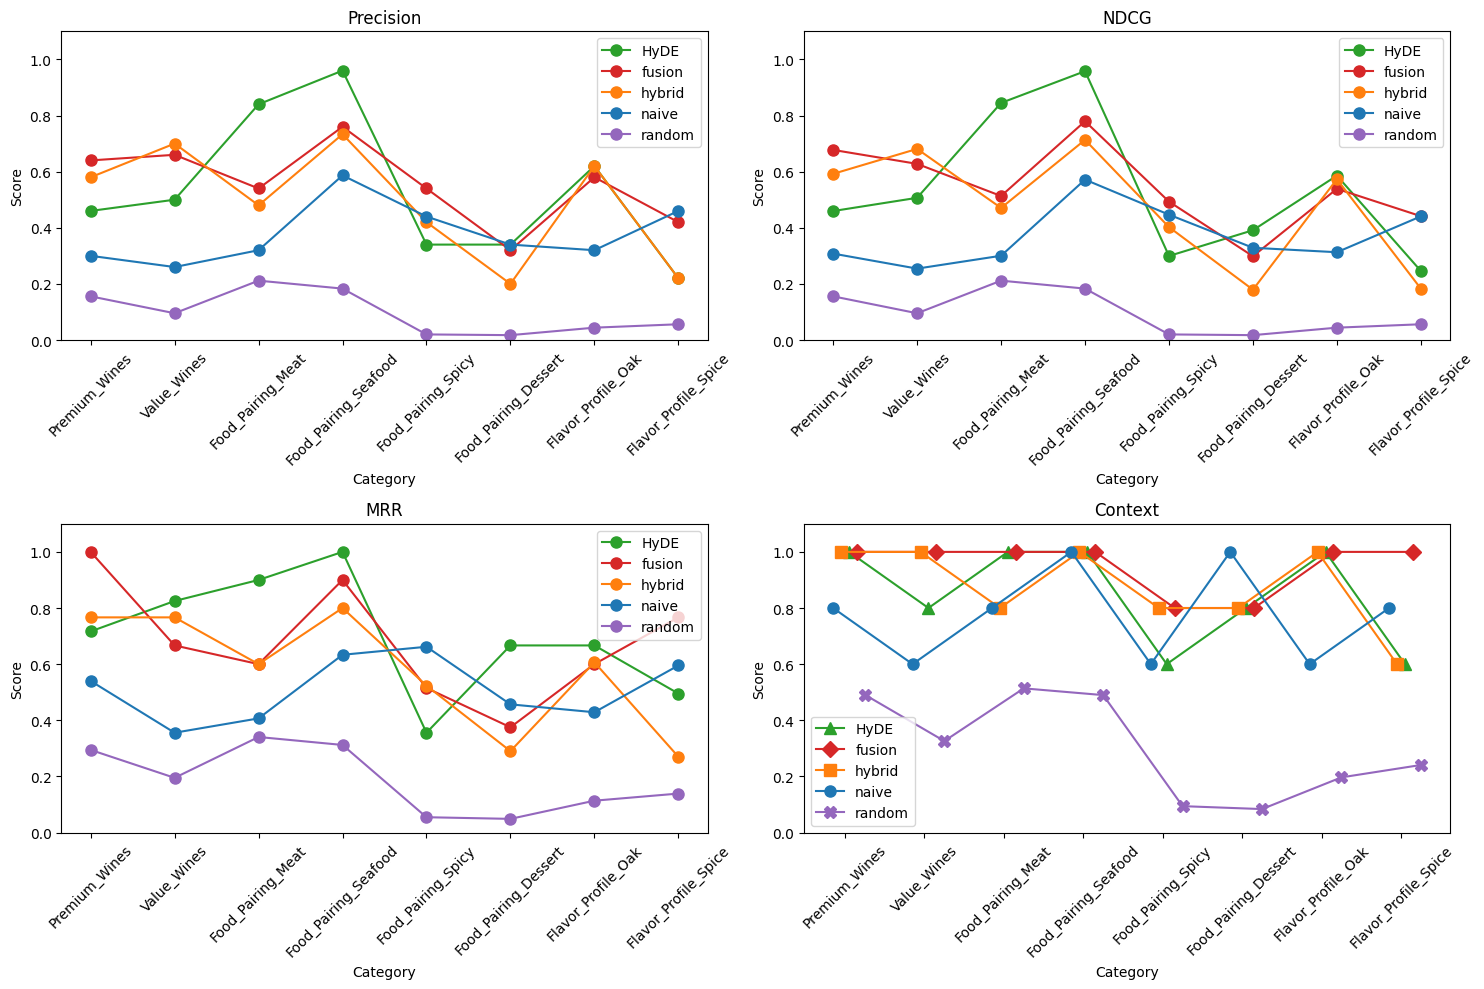

In [ ]:
combined_df_with_random = combined_df.copy()

for cat, metric in combined_df.columns:
    if cat in avg_metrics_random and metric in avg_metrics_random[cat]:
        combined_df_with_random.loc['random', (cat, metric)] = avg_metrics_random[cat][metric]

combined_df_with_random = combined_df_with_random.sort_index(axis=0)

plot_metrics_df(combined_df_with_random)

plt.show()

journal

In [ ]:
combined_df_real = combine_category_metrics(results_by_category_journal)
combined_df_real

is_in journal                                 is_top_red            \
        Precision@10   NDCG@10       MRR Context@5 Precision@10   NDCG@10   
naive           0.04  0.055545  0.200000       0.4         0.04  0.071791   
hybrid          0.08  0.105848  0.280000       0.6         0.06  0.066810   
HyDE            0.10  0.132969  0.422222       0.4         0.04  0.028930   
fusion          0.04  0.055545  0.200000       0.4         0.02  0.044018   

                           is_top_white                                
             MRR Context@5 Precision@10   NDCG@10       MRR Context@5  
naive   0.200000       0.2         0.00  0.000000  0.000000       0.0  
hybrid  0.140000       0.4         0.06  0.071791  0.166667       0.4  
HyDE    0.033333       0.0         0.10  0.142754  0.466667       0.6  
fusion  0.200000       0.2         0.00  0.000000  0.000000       0.0

In [ ]:
combined_df_real.to_csv('all-mpnet-base-v2_journal_by_cat.csv')

In [ ]:
average_metrics_per_method(combined_df_real)

,Precision,NDCG,MRR,Context
naive,0.026667,0.042445,0.133333,0.200000
hybrid,0.066667,0.081483,0.195556,0.466667
HyDE,0.080000,0.101551,0.307407,0.333333
fusion,0.020000,0.033188,0.133333,0.200000


In [ ]:
average_metrics_per_method(combined_df_real).to_csv('all-mpnet-base-v2_journal_average.csv')

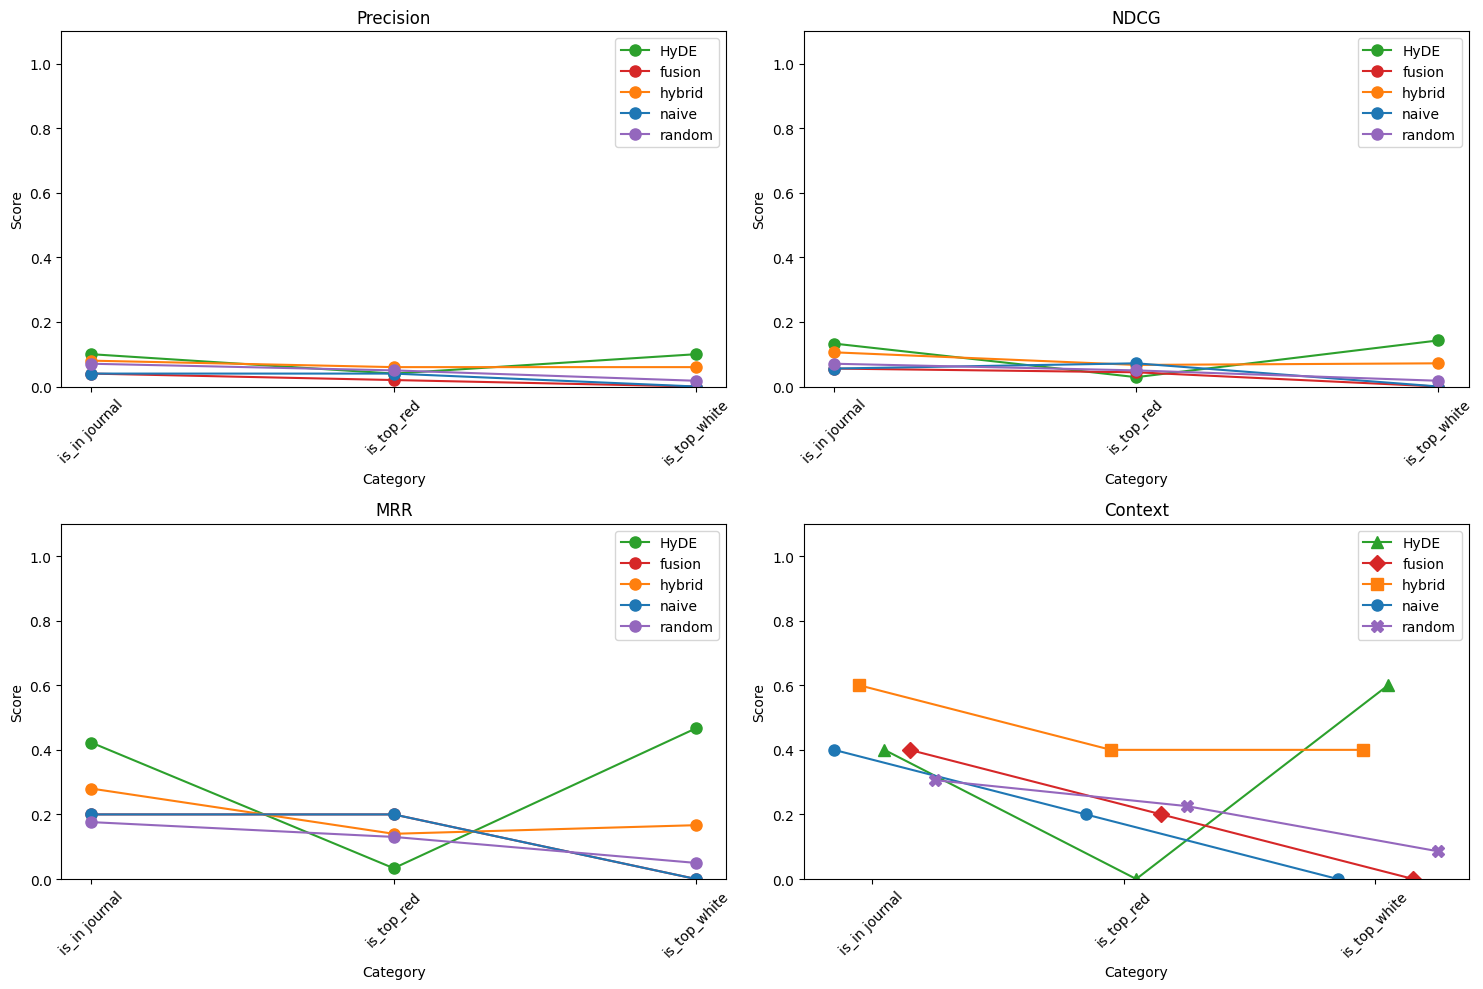

In [ ]:
combined_df_with_random_journal = combined_df_real.copy()

for cat, metric in combined_df_real.columns:
    if cat in avg_metrics_random_journal and metric in avg_metrics_random_journal[cat]:
        combined_df_with_random_journal.loc['random', (cat, metric)] = avg_metrics_random_journal[cat][metric]

combined_df_with_random_journal = combined_df_with_random_journal.sort_index(axis=0)

plot_metrics_df(combined_df_with_random_journal)
plt.show()

## all-roberta-large-v1

In [30]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS

embedding_fn = HuggingFaceEmbeddings(model_name="all-roberta-large-v1")
vectorstore = FAISS.from_documents(documents, embedding_fn)
print("FAISS vector store built with", vectorstore.index.ntotal, "documents using all-roberta-large-v1.")

<ipython-input-30-7486b4b4bc09>:4: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_fn = HuggingFaceEmbeddings(model_name="all-roberta-large-v1")
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warni

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/9.68k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/328 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

FAISS vector store built with 6312 documents using all-roberta-large-v1.


In [ ]:
# vectorstore.save_local("faiss_store")

### premium

In [ ]:
results_by_category = {}

In [ ]:
config = evaluation_configs['Premium_Wines']
queries = config['queries']
target_values = config['target_values']
test_fields = config['test_fields']

avg_metrics, query_metrics = evaluate_multiple_queries_combined(queries, vectorstore, client, df, test_fields, target_values, k=10)

In [ ]:
avg_metrics

{'naive': {'Precision@10': 0.26,
  'NDCG@10': 0.2640224191474719,
  'MRR': 0.47857142857142854,
  'Context@5': 0.6},
 'hybrid': {'Precision@10': 0.6,
  'NDCG@10': 0.5784789318480748,
  'MRR': 0.75,
  'Context@5': 1.0},
 'HyDE': {'Precision@10': 0.38,
  'NDCG@10': 0.3691564300348955,
  'MRR': 0.41666666666666663,
  'Context@5': 0.8},
 'fusion': {'Precision@10': 0.4,
  'NDCG@10': 0.3885387837284043,
  'MRR': 0.4666666666666667,
  'Context@5': 0.8}}

In [ ]:
results_by_category['Premium_Wines'] = avg_metrics

### value

In [ ]:
config = evaluation_configs['Value_Wines']
queries = config['queries']
target_values = config['target_values']
test_fields = config['test_fields']

avg_metrics, query_metrics = evaluate_multiple_queries_combined(queries, vectorstore, client, df, test_fields, target_values, k=10)

In [ ]:
avg_metrics

{'naive': {'Precision@10': 0.28,
  'NDCG@10': 0.2203690287682653,
  'MRR': 0.24666666666666667,
  'Context@5': 0.6},
 'hybrid': {'Precision@10': 0.54,
  'NDCG@10': 0.4752454810829322,
  'MRR': 0.4666666666666666,
  'Context@5': 1.0},
 'HyDE': {'Precision@10': 0.5800000000000001,
  'NDCG@10': 0.5149694563887436,
  'MRR': 0.5066666666666666,
  'Context@5': 1.0},
 'fusion': {'Precision@10': 0.43999999999999995,
  'NDCG@10': 0.36217946727456474,
  'MRR': 0.36666666666666664,
  'Context@5': 1.0}}

In [ ]:
results_by_category['Value_Wines'] = avg_metrics

### meat

In [ ]:
config = evaluation_configs['Food_Pairing_Meat']
queries = config['queries']
target_values = config['target_values']
test_fields = config['test_fields']

avg_metrics, query_metrics = evaluate_multiple_queries_combined(queries, vectorstore, client, df, test_fields, target_values, k=10)

In [ ]:
avg_metrics

{'naive': {'Precision@10': 0.32,
  'NDCG@10': 0.29231373694850954,
  'MRR': 0.29,
  'Context@5': 0.6},
 'hybrid': {'Precision@10': 0.68,
  'NDCG@10': 0.6551556706097171,
  'MRR': 0.625,
  'Context@5': 0.8},
 'HyDE': {'Precision@10': 0.8400000000000001,
  'NDCG@10': 0.8195889955347246,
  'MRR': 0.85,
  'Context@5': 1.0},
 'fusion': {'Precision@10': 0.7,
  'NDCG@10': 0.7669563164655856,
  'MRR': 1.0,
  'Context@5': 1.0}}

In [ ]:
results_by_category['Food_Pairing_Meat'] = avg_metrics

### seafood

In [ ]:
config = evaluation_configs['Food_Pairing_Seafood']
queries = config['queries']
target_values = config['target_values']
test_fields = config['test_fields']

avg_metrics, query_metrics = evaluate_multiple_queries_combined(queries, vectorstore, client, df, test_fields, target_values, k=10)

In [ ]:
avg_metrics

{'naive': {'Precision@10': 0.54,
  'NDCG@10': 0.5030141888685457,
  'MRR': 0.6166666666666666,
  'Context@5': 1.0},
 'hybrid': {'Precision@10': 0.64,
  'NDCG@10': 0.6594594515032937,
  'MRR': 0.9,
  'Context@5': 1.0},
 'HyDE': {'Precision@10': 0.9399999999999998,
  'NDCG@10': 0.9525425080906114,
  'MRR': 1.0,
  'Context@5': 1.0},
 'fusion': {'Precision@10': 0.7000000000000001,
  'NDCG@10': 0.7629482413167645,
  'MRR': 1.0,
  'Context@5': 1.0}}

In [ ]:
results_by_category['Food_Pairing_Seafood'] = avg_metrics

### spicy food

In [ ]:
config = evaluation_configs['Food_Pairing_Spicy']
queries = config['queries']
target_values = config['target_values']
test_fields = config['test_fields']

avg_metrics, query_metrics = evaluate_multiple_queries_combined(queries, vectorstore, client, df, test_fields, target_values, k=10)

In [ ]:
avg_metrics

{'naive': {'Precision@10': 0.27999999999999997,
  'NDCG@10': 0.2394450124865027,
  'MRR': 0.3019047619047619,
  'Context@5': 0.8},
 'hybrid': {'Precision@10': 0.38,
  'NDCG@10': 0.3119632934807679,
  'MRR': 0.24166666666666664,
  'Context@5': 0.6},
 'HyDE': {'Precision@10': 0.42000000000000004,
  'NDCG@10': 0.3593247777902035,
  'MRR': 0.3416666666666667,
  'Context@5': 0.8},
 'fusion': {'Precision@10': 0.44000000000000006,
  'NDCG@10': 0.36259009182294155,
  'MRR': 0.2983333333333333,
  'Context@5': 0.8}}

In [ ]:
results_by_category['Food_Pairing_Spicy'] = avg_metrics

### dessert

In [ ]:
config = evaluation_configs['Food_Pairing_Dessert']
queries = config['queries']
target_values = config['target_values']
test_fields = config['test_fields']

avg_metrics, query_metrics = evaluate_multiple_queries_combined(queries, vectorstore, client, df, test_fields, target_values, k=10)

In [ ]:
avg_metrics

{'naive': {'Precision@10': 0.54,
  'NDCG@10': 0.5029626497741623,
  'MRR': 0.6833333333333333,
  'Context@5': 0.8},
 'hybrid': {'Precision@10': 0.56,
  'NDCG@10': 0.535308734797728,
  'MRR': 0.74,
  'Context@5': 1.0},
 'HyDE': {'Precision@10': 0.33999999999999997,
  'NDCG@10': 0.36766832457020837,
  'MRR': 0.6666666666666666,
  'Context@5': 0.8},
 'fusion': {'Precision@10': 0.74,
  'NDCG@10': 0.7245273867281798,
  'MRR': 0.9,
  'Context@5': 1.0}}

In [ ]:
results_by_category['Food_Pairing_Dessert'] = avg_metrics

### oak

In [ ]:
config = evaluation_configs['Flavor_Profile_Oak']
queries = config['queries']
target_values = config['target_values']
test_fields = config['test_fields']

avg_metrics, query_metrics = evaluate_multiple_queries_combined(queries, vectorstore, client, df, test_fields, target_values, k=10)

In [ ]:
avg_metrics

{'naive': {'Precision@10': 0.27999999999999997,
  'NDCG@10': 0.21042072545754556,
  'MRR': 0.18888888888888888,
  'Context@5': 0.4},
 'hybrid': {'Precision@10': 0.27999999999999997,
  'NDCG@10': 0.24080785114291858,
  'MRR': 0.25,
  'Context@5': 0.6},
 'HyDE': {'Precision@10': 0.6,
  'NDCG@10': 0.5523280809471602,
  'MRR': 0.5666666666666667,
  'Context@5': 0.8},
 'fusion': {'Precision@10': 0.48,
  'NDCG@10': 0.43834329938907624,
  'MRR': 0.475,
  'Context@5': 0.8}}

In [ ]:
results_by_category['Flavor_Profile_Oak'] = avg_metrics

### spice

In [ ]:
config = evaluation_configs['Flavor_Profile_Spice']
queries = config['queries']
target_values = config['target_values']
test_fields = config['test_fields']

avg_metrics, query_metrics = evaluate_multiple_queries_combined(queries, vectorstore, client, df, test_fields, target_values, k=10)

In [ ]:
avg_metrics

{'naive': {'Precision@10': 0.5,
  'NDCG@10': 0.5417112276282061,
  'MRR': 0.8400000000000001,
  'Context@5': 1.0},
 'hybrid': {'Precision@10': 0.16,
  'NDCG@10': 0.17531999854422492,
  'MRR': 0.41666666666666663,
  'Context@5': 0.6},
 'HyDE': {'Precision@10': 0.21999999999999997,
  'NDCG@10': 0.2592339899450649,
  'MRR': 0.6666666666666667,
  'Context@5': 1.0},
 'fusion': {'Precision@10': 0.34,
  'NDCG@10': 0.4147175489720075,
  'MRR': 0.9,
  'Context@5': 1.0}}

In [ ]:
results_by_category['Flavor_Profile_Spice'] = avg_metrics

In [ ]:
combined_df = combine_category_metrics(results_by_category)
combined_df

Premium_Wines                                Value_Wines            \
        Precision@10   NDCG@10       MRR Context@5 Precision@10   NDCG@10   
naive           0.26  0.264022  0.478571       0.6         0.28  0.220369   
hybrid          0.60  0.578479  0.750000       1.0         0.54  0.475245   
HyDE            0.38  0.369156  0.416667       0.8         0.58  0.514969   
fusion          0.40  0.388539  0.466667       0.8         0.44  0.362179   

                           Food_Pairing_Meat                             \
             MRR Context@5      Precision@10   NDCG@10    MRR Context@5   
naive   0.246667       0.6              0.32  0.292314  0.290       0.6   
hybrid  0.466667       1.0              0.68  0.655156  0.625       0.8   
HyDE    0.506667       1.0              0.84  0.819589  0.850       1.0   
fusion  0.366667       1.0              0.70  0.766956  1.000       1.0   

       Food_Pairing_Seafood                               Food_Pairing_Spicy  \
               Precision@10   NDCG@10       MRR Context@5       Precision@10   
naive                  0.54  0.503014  0.616667       1.0               0.28   
hybrid                 0.64  0.659459  0.900000       1.0               0.38   
HyDE                   0.94  0.952543  1.000000       1.0               0.42   
fusion                 0.70  0.762948  1.000000       1.0               0.44   

                                     Food_Pairing_Dessert                      \
         NDCG@10       MRR Context@5         Precision@10   NDCG@10       MRR   
naive   0.239445  0.301905       0.8                 0.54  0.502963  0.683333   
hybrid  0.311963  0.241667       0.6                 0.56  0.535309  0.740000   
HyDE    0.359325  0.341667       0.8                 0.34  0.367668  0.666667   
fusion  0.362590  0.298333       0.8                 0.74  0.724527  0.900000   

                 Flavor_Profile_Oak                                \
       Context@5       Precision@10   NDCG@10       MRR Context@5   
naive        0.8               0.28  0.210421  0.188889       0.4   
hybrid       1.0               0.28  0.240808  0.250000       0.6   
HyDE         0.8               0.60  0.552328  0.566667       0.8   
fusion       1.0               0.48  0.438343  0.475000       0.8   

       Flavor_Profile_Spice                                
               Precision@10   NDCG@10       MRR Context@5  
naive                  0.28  0.210421  0.188889       0.4  
hybrid                 0.28  0.240808  0.250000       0.6  
HyDE                   0.60  0.552328  0.566667       0.8  
fusion                 0.48  0.438343  0.475000       0.8

In [ ]:
combined_df.to_csv('all-roberta-large-v1_metrics_by_cat.csv')

In [ ]:
average_metrics_per_method(combined_df)

,Precision,NDCG,MRR,Context
naive,0.3475,0.305371,0.374365,0.650
hybrid,0.4950,0.462153,0.527917,0.825
HyDE,0.5875,0.560988,0.614375,0.875
fusion,0.5475,0.530553,0.622708,0.900


In [ ]:
average_metrics_per_method(combined_df).to_csv('all-roberta-large-v1_metrics_avg.csv')

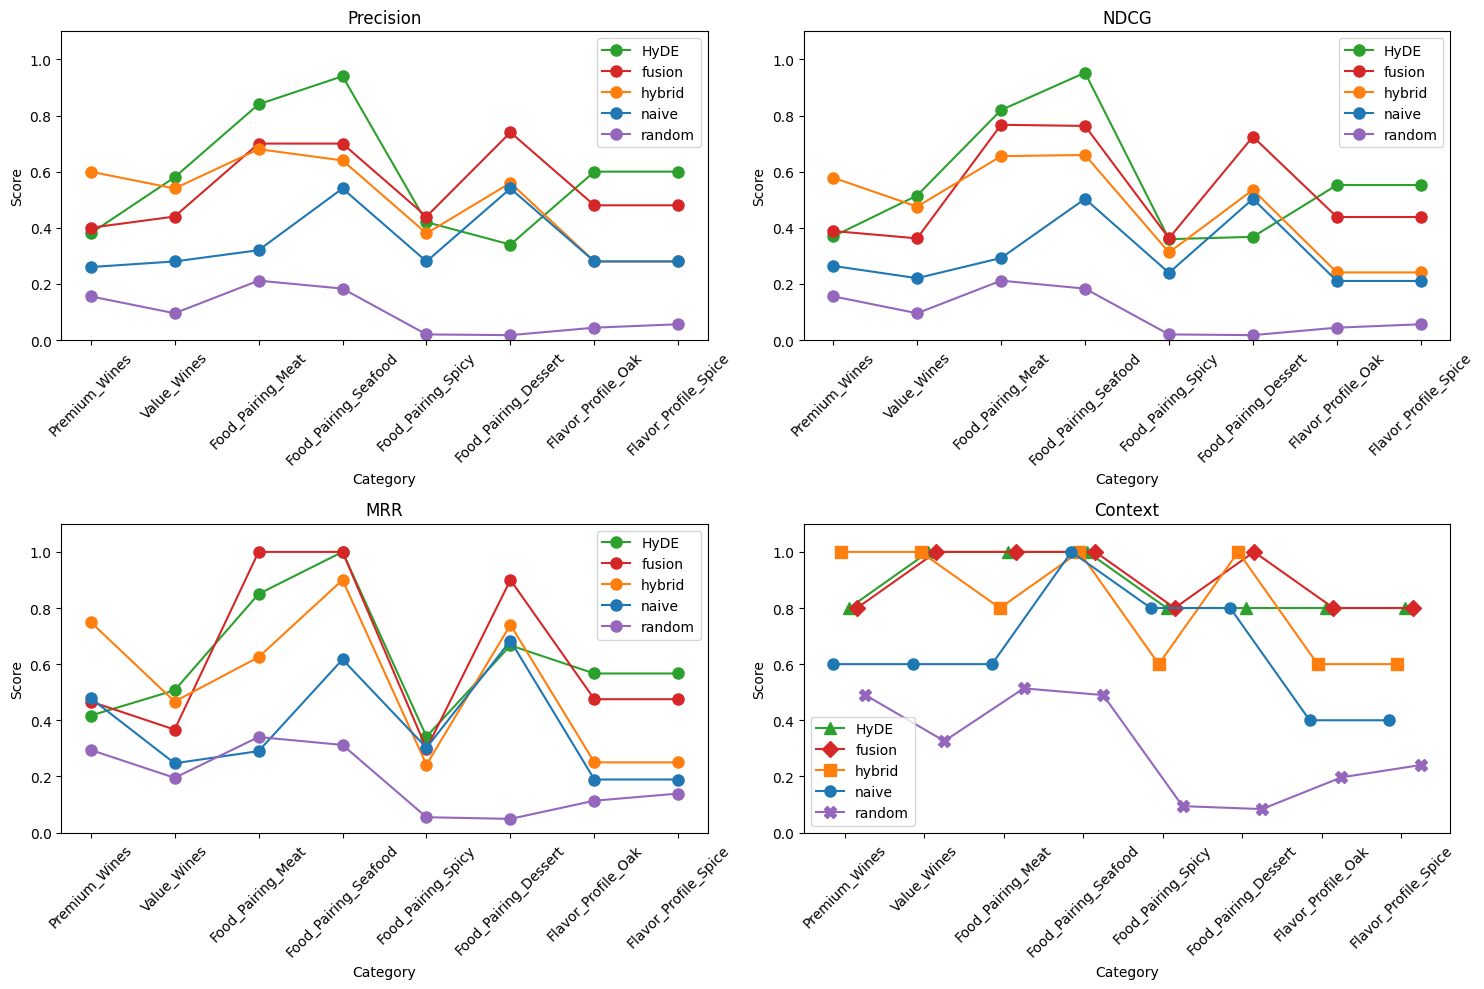

In [ ]:
combined_df_with_random = combined_df.copy()

for cat, metric in combined_df.columns:
    if cat in avg_metrics_random and metric in avg_metrics_random[cat]:
        combined_df_with_random.loc['random', (cat, metric)] = avg_metrics_random[cat][metric]

combined_df_with_random = combined_df_with_random.sort_index(axis=0)

plot_metrics_df(combined_df_with_random)

plt.show()

### journal

In [ ]:
results_by_category_journal = {}

In [ ]:
config = evaluation_configs_real['is_in journal']
queries = config['queries']
target_values = config['target_values']
test_fields = config['test_fields']

avg_metrics, query_metrics = evaluate_multiple_queries_combined(queries, vectorstore, client, df, test_fields, target_values, k=10)

In [ ]:
avg_metrics

{'naive': {'Precision@10': 0.12,
  'NDCG@10': 0.16087162050336254,
  'MRR': 0.5,
  'Context@5': 1.0},
 'hybrid': {'Precision@10': 0.13999999999999999,
  'NDCG@10': 0.23738170273278883,
  'MRR': 0.8,
  'Context@5': 1.0},
 'HyDE': {'Precision@10': 0.14,
  'NDCG@10': 0.17017802982457786,
  'MRR': 0.5166666666666666,
  'Context@5': 0.8},
 'fusion': {'Precision@10': 0.18,
  'NDCG@10': 0.22053482997460638,
  'MRR': 0.5166666666666667,
  'Context@5': 1.0}}

In [ ]:
results_by_category_journal['is_in journal'] = avg_metrics

In [ ]:
config = evaluation_configs_real['is_top_red']
queries = config['queries']
target_values = config['target_values']
test_fields = config['test_fields']

avg_metrics, query_metrics = evaluate_multiple_queries_combined(queries, vectorstore, client, df, test_fields, target_values, k=10)

In [ ]:
avg_metrics

{'naive': {'Precision@10': 0.08,
  'NDCG@10': 0.15406423640865613,
  'MRR': 0.6666666666666667,
  'Context@5': 0.8},
 'hybrid': {'Precision@10': 0.08,
  'NDCG@10': 0.15982754855355902,
  'MRR': 0.7,
  'Context@5': 0.8},
 'HyDE': {'Precision@10': 0.1,
  'NDCG@10': 0.07343249424005685,
  'MRR': 0.12666666666666665,
  'Context@5': 0.2},
 'fusion': {'Precision@10': 0.06000000000000001,
  'NDCG@10': 0.1320550597788481,
  'MRR': 0.6,
  'Context@5': 0.6}}

In [ ]:
results_by_category_journal['is_top_red'] = avg_metrics

In [ ]:
config = evaluation_configs_real['is_top_white']
queries = config['queries']
target_values = config['target_values']
test_fields = config['test_fields']

avg_metrics, query_metrics = evaluate_multiple_queries_combined(queries, vectorstore, client, df, test_fields, target_values, k=10)

In [ ]:
avg_metrics

{'naive': {'Precision@10': 0.02,
  'NDCG@10': 0.018957672873910154,
  'MRR': 0.05,
  'Context@5': 0.2},
 'hybrid': {'Precision@10': 0.06000000000000001,
  'NDCG@10': 0.06104697678794023,
  'MRR': 0.17333333333333334,
  'Context@5': 0.6},
 'HyDE': {'Precision@10': 0.08,
  'NDCG@10': 0.12088062378049769,
  'MRR': 0.45,
  'Context@5': 0.6},
 'fusion': {'Precision@10': 0.0, 'NDCG@10': 0.0, 'MRR': 0.0, 'Context@5': 0.0}}

In [ ]:
results_by_category_journal['is_top_white'] = avg_metrics

In [ ]:
combined_df_real = combine_category_metrics(results_by_category_journal)
combined_df_real

is_in journal                                 is_top_red            \
        Precision@10   NDCG@10       MRR Context@5 Precision@10   NDCG@10   
naive           0.12  0.160872  0.500000       1.0         0.08  0.154064   
hybrid          0.14  0.237382  0.800000       1.0         0.08  0.159828   
HyDE            0.14  0.170178  0.516667       0.8         0.10  0.073432   
fusion          0.18  0.220535  0.516667       1.0         0.06  0.132055   

                           is_top_white                                
             MRR Context@5 Precision@10   NDCG@10       MRR Context@5  
naive   0.666667       0.8         0.02  0.018958  0.050000       0.2  
hybrid  0.700000       0.8         0.06  0.061047  0.173333       0.6  
HyDE    0.126667       0.2         0.08  0.120881  0.450000       0.6  
fusion  0.600000       0.6         0.00  0.000000  0.000000       0.0

In [ ]:
combined_df_real.to_csv('all-roberta-large-v1_journal_by_cat.csv')

In [ ]:
average_metrics_per_method(combined_df_real)

,Precision,NDCG,MRR,Context
naive,0.073333,0.111298,0.405556,0.666667
hybrid,0.093333,0.152752,0.557778,0.800000
HyDE,0.106667,0.121497,0.364444,0.533333
fusion,0.080000,0.117530,0.372222,0.533333


In [ ]:
average_metrics_per_method(combined_df_real).to_csv('all-roberta-large-v1_journal_avg.csv')

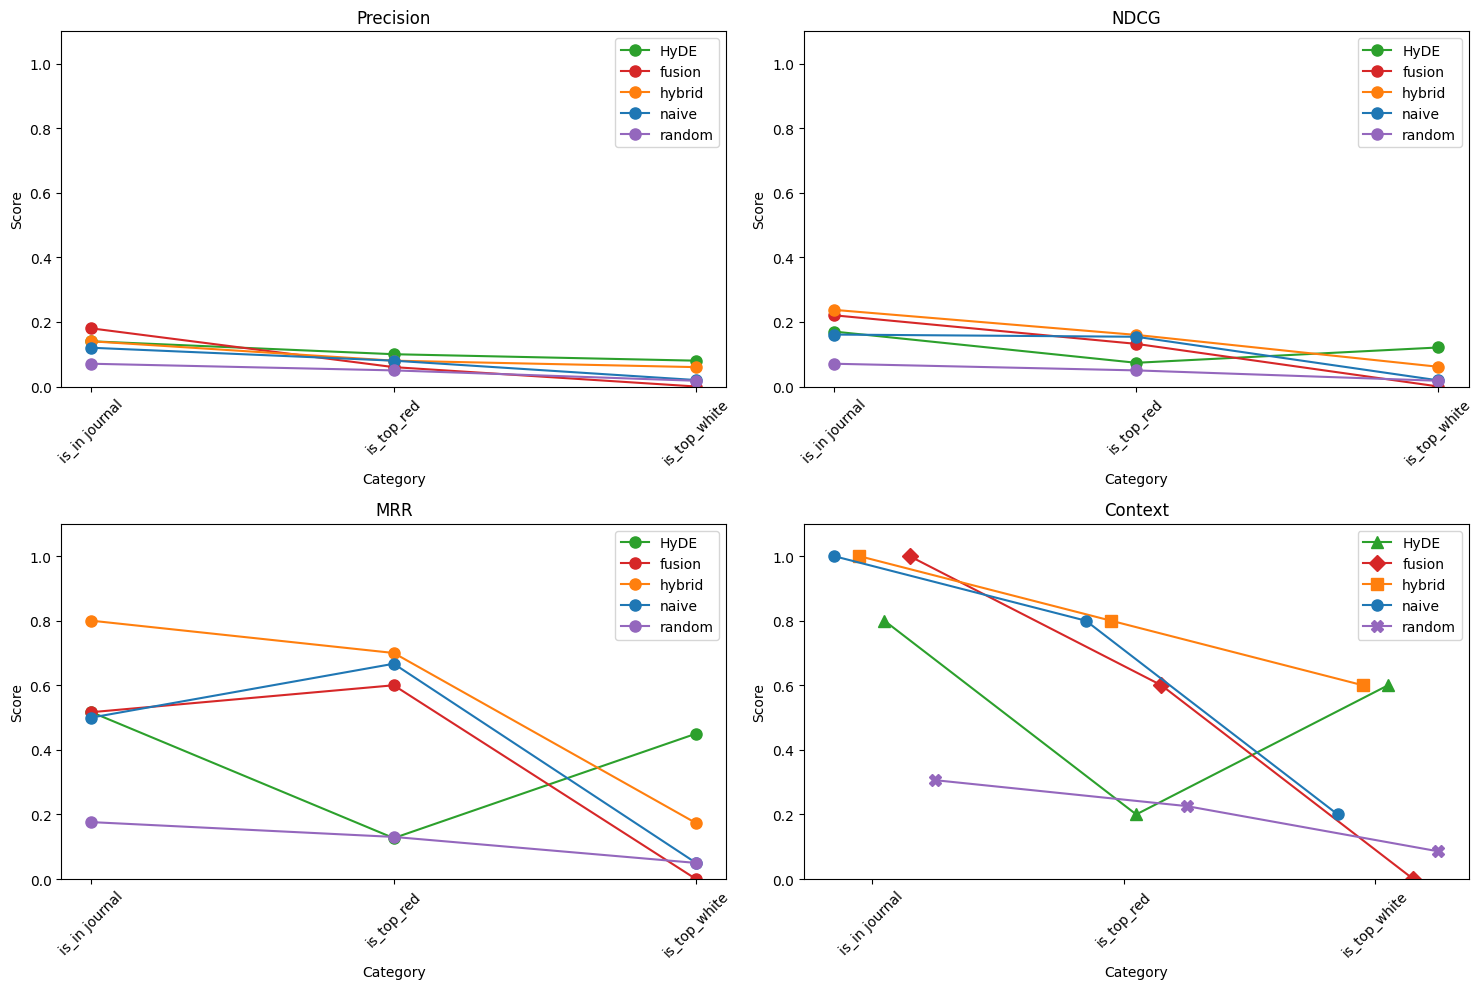

In [ ]:
combined_df_with_random_journal = combined_df_real.copy()

for cat, metric in combined_df_real.columns:
    if cat in avg_metrics_random_journal and metric in avg_metrics_random_journal[cat]:
        combined_df_with_random_journal.loc['random', (cat, metric)] = avg_metrics_random_journal[cat][metric]

combined_df_with_random_journal = combined_df_with_random_journal.sort_index(axis=0)

plot_metrics_df(combined_df_with_random_journal)
plt.show()

## text-embedding-3-large

In [ ]:
# from langchain.embeddings import OpenAIEmbeddings

# embedding_fn = OpenAIEmbeddings(model="text-embedding-3-large")
# vectorstore = FAISS.from_documents(documents, embedding_fn)
# print("FAISS vector store built with", vectorstore.index.ntotal, "documents using text-embedding-3-large")

FAISS vector store built with 6312 documents using text-embedding-3-large


In [25]:
from langchain.vectorstores import FAISS
from langchain.embeddings import OpenAIEmbeddings

embedding_fn = OpenAIEmbeddings(model="text-embedding-3-large")
vectorstore = FAISS.load_local("/content/faiss_index", embedding_fn, allow_dangerous_deserialization=True)
print("Loaded FAISS vector store with", vectorstore.index.ntotal, "documents.")

<ipython-input-25-282c68d7fe58>:4: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embedding_fn = OpenAIEmbeddings(model="text-embedding-3-large")


Loaded FAISS vector store with 6312 documents.


In [ ]:
results_by_category = {}

### premium wines

In [ ]:
config = evaluation_configs['Premium_Wines']
queries = config['queries']
target_values = config['target_values']
test_fields = config['test_fields']

avg_metrics, query_metrics = evaluate_multiple_queries_combined(queries, vectorstore, client, df, test_fields, target_values, k=10)

In [ ]:
avg_metrics

{'naive': {'Precision@10': 0.6599999999999999,
  'NDCG@10': 0.7052739399811677,
  'MRR': 0.8666666666666666,
  'Context@5': 1.0},
 'hybrid': {'Precision@10': 0.8,
  'NDCG@10': 0.8274795102550044,
  'MRR': 1.0,
  'Context@5': 1.0},
 'HyDE': {'Precision@10': 0.7,
  'NDCG@10': 0.7211931797346998,
  'MRR': 0.9,
  'Context@5': 1.0},
 'fusion': {'Precision@10': 0.74,
  'NDCG@10': 0.7281327278002158,
  'MRR': 0.8,
  'Context@5': 1.0}}

In [ ]:
results_by_category['Premium_Wines'] = avg_metrics

### value wines

In [ ]:
config = evaluation_configs['Value_Wines']
queries = config['queries']
target_values = config['target_values']
test_fields = config['test_fields']

avg_metrics, query_metrics = evaluate_multiple_queries_combined(queries, vectorstore, client, df, test_fields, target_values, k=10)

In [ ]:
avg_metrics

{'naive': {'Precision@10': 0.6799999999999999,
  'NDCG@10': 0.6794791264891527,
  'MRR': 0.9,
  'Context@5': 1.0},
 'hybrid': {'Precision@10': 0.78,
  'NDCG@10': 0.8138527980290329,
  'MRR': 1.0,
  'Context@5': 1.0},
 'HyDE': {'Precision@10': 0.74,
  'NDCG@10': 0.7497199260619947,
  'MRR': 0.9,
  'Context@5': 1.0},
 'fusion': {'Precision@10': 0.8,
  'NDCG@10': 0.7704954327994564,
  'MRR': 0.8,
  'Context@5': 1.0}}

In [ ]:
results_by_category['Value_Wines'] = avg_metrics

### meat

In [ ]:
config = evaluation_configs['Food_Pairing_Meat']
queries = config['queries']
target_values = config['target_values']
test_fields = config['test_fields']

avg_metrics, query_metrics = evaluate_multiple_queries_combined(queries, vectorstore, client, df, test_fields, target_values, k=10)

In [ ]:
avg_metrics

{'naive': {'Precision@10': 0.9,
  'NDCG@10': 0.8897337875076134,
  'MRR': 0.9,
  'Context@5': 1.0},
 'hybrid': {'Precision@10': 0.96,
  'NDCG@10': 0.9702472188318854,
  'MRR': 1.0,
  'Context@5': 1.0},
 'HyDE': {'Precision@10': 1.0, 'NDCG@10': 1.0, 'MRR': 1.0, 'Context@5': 1.0},
 'fusion': {'Precision@10': 0.96,
  'NDCG@10': 0.9740249976693318,
  'MRR': 1.0,
  'Context@5': 1.0}}

In [ ]:
results_by_category['Food_Pairing_Meat'] = avg_metrics

### seafood

In [ ]:
config = evaluation_configs['Food_Pairing_Seafood']
queries = config['queries']
target_values = config['target_values']
test_fields = config['test_fields']

avg_metrics, query_metrics = evaluate_multiple_queries_combined(queries, vectorstore, client, df, test_fields, target_values, k=10)

In [ ]:
avg_metrics

{'naive': {'Precision@10': 0.8400000000000001,
  'NDCG@10': 0.8499328057405577,
  'MRR': 0.9,
  'Context@5': 1.0},
 'hybrid': {'Precision@10': 0.9199999999999999,
  'NDCG@10': 0.9249759034396335,
  'MRR': 1.0,
  'Context@5': 1.0},
 'HyDE': {'Precision@10': 1.0, 'NDCG@10': 1.0, 'MRR': 1.0, 'Context@5': 1.0},
 'fusion': {'Precision@10': 0.9800000000000001,
  'NDCG@10': 0.9810423271260899,
  'MRR': 1.0,
  'Context@5': 1.0}}

In [ ]:
results_by_category['Food_Pairing_Seafood'] = avg_metrics

### pairing spicy

In [ ]:
config = evaluation_configs['Food_Pairing_Spicy']
queries = config['queries']
target_values = config['target_values']
test_fields = config['test_fields']

avg_metrics, query_metrics = evaluate_multiple_queries_combined(queries, vectorstore, client, df, test_fields, target_values, k=10)

In [ ]:
avg_metrics

{'naive': {'Precision@10': 0.54,
  'NDCG@10': 0.4986715383001834,
  'MRR': 0.5685714285714286,
  'Context@5': 0.8},
 'hybrid': {'Precision@10': 0.5,
  'NDCG@10': 0.43069665978313115,
  'MRR': 0.42000000000000004,
  'Context@5': 1.0},
 'HyDE': {'Precision@10': 0.41999999999999993,
  'NDCG@10': 0.3604868645377686,
  'MRR': 0.2833333333333333,
  'Context@5': 0.6},
 'fusion': {'Precision@10': 0.54,
  'NDCG@10': 0.4619585729230241,
  'MRR': 0.41500000000000004,
  'Context@5': 0.8}}

In [ ]:
results_by_category['Food_Pairing_Spicy'] = avg_metrics

### dessert

In [ ]:
config = evaluation_configs['Food_Pairing_Dessert']
queries = config['queries']
target_values = config['target_values']
test_fields = config['test_fields']

avg_metrics, query_metrics = evaluate_multiple_queries_combined(queries, vectorstore, client, df, test_fields, target_values, k=10)

In [ ]:
avg_metrics

{'naive': {'Precision@10': 0.9199999999999999,
  'NDCG@10': 0.9441992465048124,
  'MRR': 1.0,
  'Context@5': 1.0},
 'hybrid': {'Precision@10': 0.58,
  'NDCG@10': 0.5281104245558416,
  'MRR': 0.5333333333333333,
  'Context@5': 1.0},
 'HyDE': {'Precision@10': 1.0, 'NDCG@10': 1.0, 'MRR': 1.0, 'Context@5': 1.0},
 'fusion': {'Precision@10': 0.96,
  'NDCG@10': 0.9733895979728542,
  'MRR': 1.0,
  'Context@5': 1.0}}

In [ ]:
results_by_category['Food_Pairing_Dessert'] = avg_metrics

### oak

In [ ]:
config = evaluation_configs['Flavor_Profile_Oak']
queries = config['queries']
target_values = config['target_values']
test_fields = config['test_fields']

avg_metrics, query_metrics = evaluate_multiple_queries_combined(queries, vectorstore, client, df, test_fields, target_values, k=10)

In [ ]:
avg_metrics

{'naive': {'Precision@10': 0.6599999999999999,
  'NDCG@10': 0.6678721823456213,
  'MRR': 0.8400000000000001,
  'Context@5': 1.0},
 'hybrid': {'Precision@10': 0.6199999999999999,
  'NDCG@10': 0.5536179496071711,
  'MRR': 0.6166666666666666,
  'Context@5': 1.0},
 'HyDE': {'Precision@10': 0.6199999999999999,
  'NDCG@10': 0.533218759569771,
  'MRR': 0.55,
  'Context@5': 1.0},
 'fusion': {'Precision@10': 0.68,
  'NDCG@10': 0.6761459746748918,
  'MRR': 0.8,
  'Context@5': 1.0}}

In [ ]:
results_by_category['Flavor_Profile_Oak'] = avg_metrics

### profile spice

In [ ]:
config = evaluation_configs['Flavor_Profile_Spice']
queries = config['queries']
target_values = config['target_values']
test_fields = config['test_fields']

avg_metrics, query_metrics = evaluate_multiple_queries_combined(queries, vectorstore, client, df, test_fields, target_values, k=10)

In [ ]:
avg_metrics

{'naive': {'Precision@10': 0.6,
  'NDCG@10': 0.5892365573191174,
  'MRR': 0.7,
  'Context@5': 0.8},
 'hybrid': {'Precision@10': 0.38,
  'NDCG@10': 0.39827548355236225,
  'MRR': 0.7,
  'Context@5': 0.8},
 'HyDE': {'Precision@10': 0.34,
  'NDCG@10': 0.2911885567283193,
  'MRR': 0.32666666666666666,
  'Context@5': 0.8},
 'fusion': {'Precision@10': 0.36,
  'NDCG@10': 0.34500300693103725,
  'MRR': 0.5152380952380952,
  'Context@5': 0.6}}

In [ ]:
results_by_category['Flavor_Profile_Spice'] = avg_metrics

### journal

In [ ]:
df.columns

Index(['title', 'id', 'review_1', 'review_2', 'review_3', 'review_4',
       'review_5', 'review_6', 'review_7', 'review_8', 'review_9', 'review_10',
       'country', 'description', 'designation', 'points', 'price', 'province',
       'region_1', 'region_2', 'taster_name', 'taster_twitter_handle',
       'variety', 'winery', 'vintage', 'wine_color', 'Premium_Wines',
       'Value_Wines', 'Food_Pairing_Meat', 'Food_Pairing_Seafood',
       'Food_Pairing_Spicy', 'Food_Pairing_Dessert', 'Flavor_Profile_Spice',
       'Flavor_Profile_Oak', 'top100_year', 'color', 'top100_rank',
       'wine_type', 'is_in journal', 'is_top_red', 'is_top_white'],
      dtype='object')

In [ ]:
results_by_category_journal = {}

In [ ]:
config = evaluation_configs_real['is_in journal']
queries = config['queries']
target_values = config['target_values']
test_fields = config['test_fields']

avg_metrics, query_metrics = evaluate_multiple_queries_combined(queries, vectorstore, client, df, test_fields, target_values, k=10)

In [ ]:
avg_metrics

{'naive': {'Precision@10': 0.4,
  'NDCG@10': 0.4758374957563527,
  'MRR': 0.9,
  'Context@5': 1.0},
 'hybrid': {'Precision@10': 0.22000000000000003,
  'NDCG@10': 0.2770932532423843,
  'MRR': 0.8222222222222222,
  'Context@5': 0.8},
 'HyDE': {'Precision@10': 0.18,
  'NDCG@10': 0.2124129529113729,
  'MRR': 0.5666666666666667,
  'Context@5': 0.8},
 'fusion': {'Precision@10': 0.16,
  'NDCG@10': 0.20743618079898657,
  'MRR': 0.6485714285714286,
  'Context@5': 0.6}}

In [ ]:
results_by_category_journal['is_in journal'] = avg_metrics

In [ ]:
config = evaluation_configs_real['is_top_red']
queries = config['queries']
target_values = config['target_values']
test_fields = config['test_fields']

avg_metrics, query_metrics = evaluate_multiple_queries_combined(queries, vectorstore, client, df, test_fields, target_values, k=10)

In [ ]:
avg_metrics

{'naive': {'Precision@10': 0.24000000000000005,
  'NDCG@10': 0.31265411110753716,
  'MRR': 0.8,
  'Context@5': 0.8},
 'hybrid': {'Precision@10': 0.12,
  'NDCG@10': 0.08869117548276524,
  'MRR': 0.15436507936507934,
  'Context@5': 0.2},
 'HyDE': {'Precision@10': 0.12,
  'NDCG@10': 0.14241552028542562,
  'MRR': 0.4,
  'Context@5': 0.4},
 'fusion': {'Precision@10': 0.02,
  'NDCG@10': 0.013886244387355454,
  'MRR': 0.025,
  'Context@5': 0.0}}

In [ ]:
results_by_category_journal['is_top_red'] = avg_metrics

In [ ]:
config = evaluation_configs_real['is_top_white']
queries = config['queries']
target_values = config['target_values']
test_fields = config['test_fields']

avg_metrics, query_metrics = evaluate_multiple_queries_combined(queries, vectorstore, client, df, test_fields, target_values, k=10)

In [ ]:
avg_metrics

{'naive': {'Precision@10': 0.26,
  'NDCG@10': 0.32896286850647793,
  'MRR': 0.7666666666666667,
  'Context@5': 1.0},
 'hybrid': {'Precision@10': 0.13999999999999999,
  'NDCG@10': 0.20960921395807794,
  'MRR': 0.6666666666666667,
  'Context@5': 1.0},
 'HyDE': {'Precision@10': 0.16,
  'NDCG@10': 0.1823400538108613,
  'MRR': 0.42857142857142855,
  'Context@5': 0.6},
 'fusion': {'Precision@10': 0.13999999999999999,
  'NDCG@10': 0.1564162945280108,
  'MRR': 0.39166666666666666,
  'Context@5': 0.6}}

In [ ]:
results_by_category_journal['is_top_white'] = avg_metrics

### results

llm labels

In [ ]:
combined_df = combine_category_metrics(results_by_category)
combined_df

Premium_Wines                                Value_Wines            \
        Precision@10   NDCG@10       MRR Context@5 Precision@10   NDCG@10   
naive           0.66  0.705274  0.866667       1.0         0.68  0.679479   
hybrid          0.80  0.827480  1.000000       1.0         0.78  0.813853   
HyDE            0.70  0.721193  0.900000       1.0         0.74  0.749720   
fusion          0.74  0.728133  0.800000       1.0         0.80  0.770495   

                      Food_Pairing_Meat                           \
        MRR Context@5      Precision@10   NDCG@10  MRR Context@5   
naive   0.9       1.0              0.90  0.889734  0.9       1.0   
hybrid  1.0       1.0              0.96  0.970247  1.0       1.0   
HyDE    0.9       1.0              1.00  1.000000  1.0       1.0   
fusion  0.8       1.0              0.96  0.974025  1.0       1.0   

       Food_Pairing_Seafood                          Food_Pairing_Spicy  \
               Precision@10   NDCG@10  MRR Context@5       Precision@10   
naive                  0.84  0.849933  0.9       1.0               0.54   
hybrid                 0.92  0.924976  1.0       1.0               0.50   
HyDE                   1.00  1.000000  1.0       1.0               0.42   
fusion                 0.98  0.981042  1.0       1.0               0.54   

                                     Food_Pairing_Dessert                      \
         NDCG@10       MRR Context@5         Precision@10   NDCG@10       MRR   
naive   0.498672  0.568571       0.8                 0.92  0.944199  1.000000   
hybrid  0.430697  0.420000       1.0                 0.58  0.528110  0.533333   
HyDE    0.360487  0.283333       0.6                 1.00  1.000000  1.000000   
fusion  0.461959  0.415000       0.8                 0.96  0.973390  1.000000   

                 Flavor_Profile_Oak                                \
       Context@5       Precision@10   NDCG@10       MRR Context@5   
naive        1.0               0.66  0.667872  0.840000       1.0   
hybrid       1.0               0.62  0.553618  0.616667       1.0   
HyDE         1.0               0.62  0.533219  0.550000       1.0   
fusion       1.0               0.68  0.676146  0.800000       1.0   

       Flavor_Profile_Spice                                
               Precision@10   NDCG@10       MRR Context@5  
naive                  0.60  0.589237  0.700000       0.8  
hybrid                 0.38  0.398275  0.700000       0.8  
HyDE                   0.34  0.291189  0.326667       0.8  
fusion                 0.36  0.345003  0.515238       0.6

In [ ]:
combined_df.to_csv('text-embedding-3-large_metrics_by_cat.csv')

In [ ]:
average_metrics_per_method(combined_df)

,Precision,NDCG,MRR,Context
naive,0.7250,0.728050,0.834405,0.950
hybrid,0.6925,0.680907,0.783750,0.975
HyDE,0.7275,0.706976,0.745000,0.925
fusion,0.7525,0.738774,0.791280,0.925


In [ ]:
average_metrics_per_method(combined_df).to_csv('text-embedding-3-large_avg_metrics.csv')

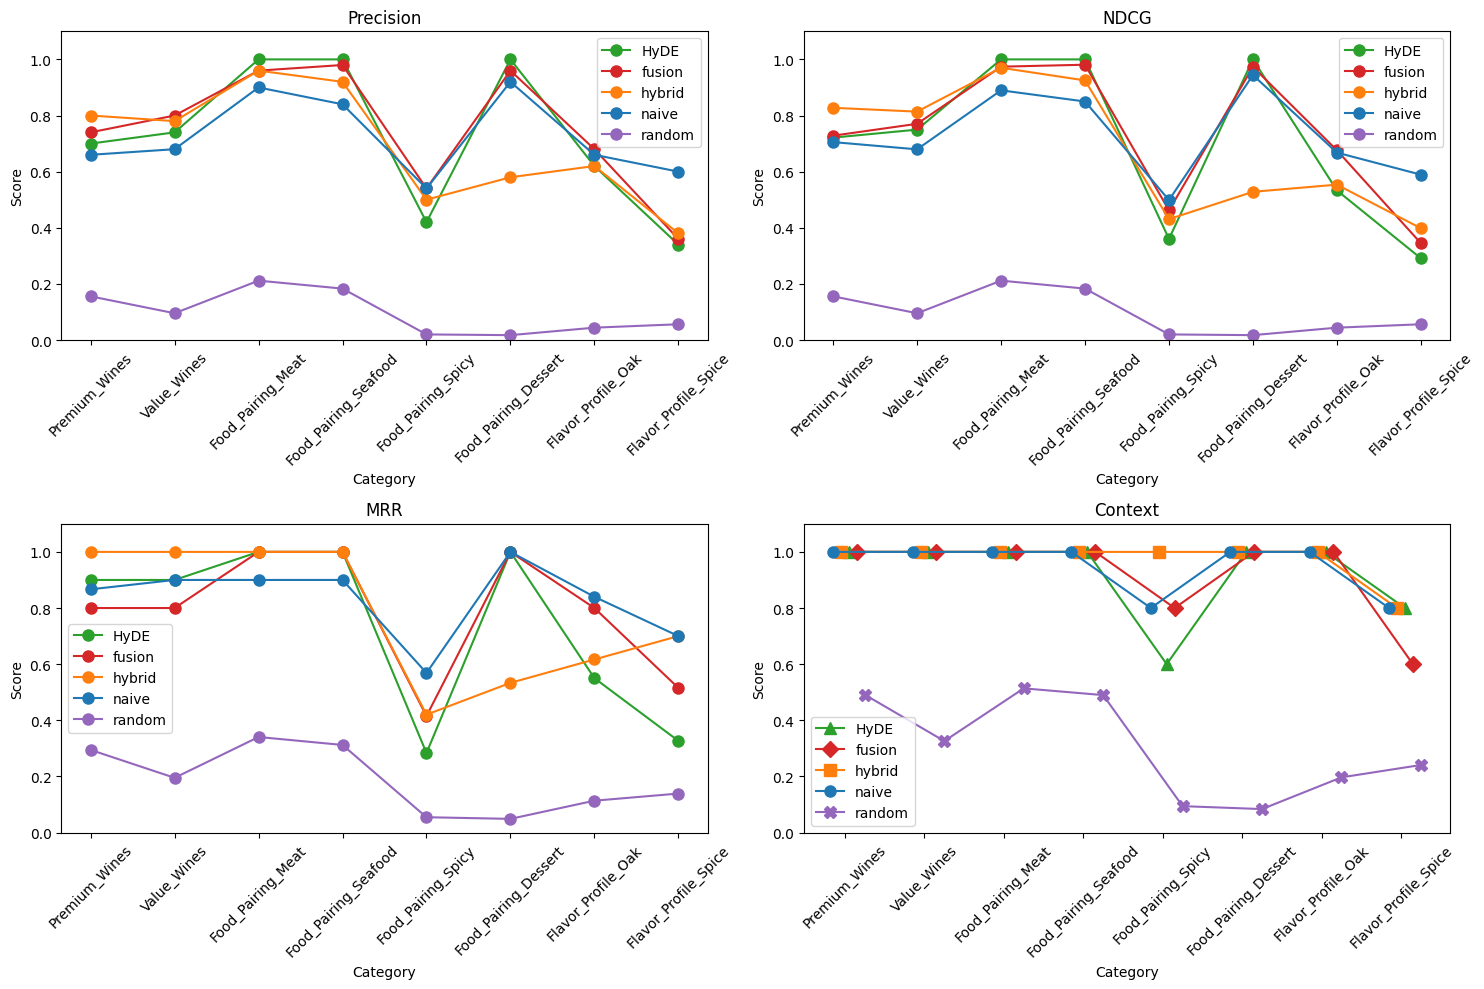

In [ ]:
combined_df_with_random = combined_df.copy()

for cat, metric in combined_df.columns:
    if cat in avg_metrics_random and metric in avg_metrics_random[cat]:
        combined_df_with_random.loc['random', (cat, metric)] = avg_metrics_random[cat][metric]

combined_df_with_random = combined_df_with_random.sort_index(axis=0)

plot_metrics_df(combined_df_with_random)

plt.show()

journal

In [ ]:
combined_df_real = combine_category_metrics(results_by_category_journal)
combined_df_real

is_in journal                                 is_top_red            \
        Precision@10   NDCG@10       MRR Context@5 Precision@10   NDCG@10   
naive           0.40  0.475837  0.900000       1.0         0.24  0.312654   
hybrid          0.22  0.277093  0.822222       0.8         0.12  0.088691   
HyDE            0.18  0.212413  0.566667       0.8         0.12  0.142416   
fusion          0.16  0.207436  0.648571       0.6         0.02  0.013886   

                           is_top_white                                
             MRR Context@5 Precision@10   NDCG@10       MRR Context@5  
naive   0.800000       0.8         0.26  0.328963  0.766667       1.0  
hybrid  0.154365       0.2         0.14  0.209609  0.666667       1.0  
HyDE    0.400000       0.4         0.16  0.182340  0.428571       0.6  
fusion  0.025000       0.0         0.14  0.156416  0.391667       0.6

In [ ]:
combined_df_real.to_csv('text-embedding-3-large_journal_by_cat.csv')

In [ ]:
average_metrics_per_method(combined_df_real)

,Precision,NDCG,MRR,Context
naive,0.300000,0.372485,0.822222,0.933333
hybrid,0.160000,0.191798,0.547751,0.666667
HyDE,0.153333,0.179056,0.465079,0.600000
fusion,0.106667,0.125913,0.355079,0.400000


In [ ]:
average_metrics_per_method(combined_df_real).to_csv('text-embedding-3-large_journal_average.csv')

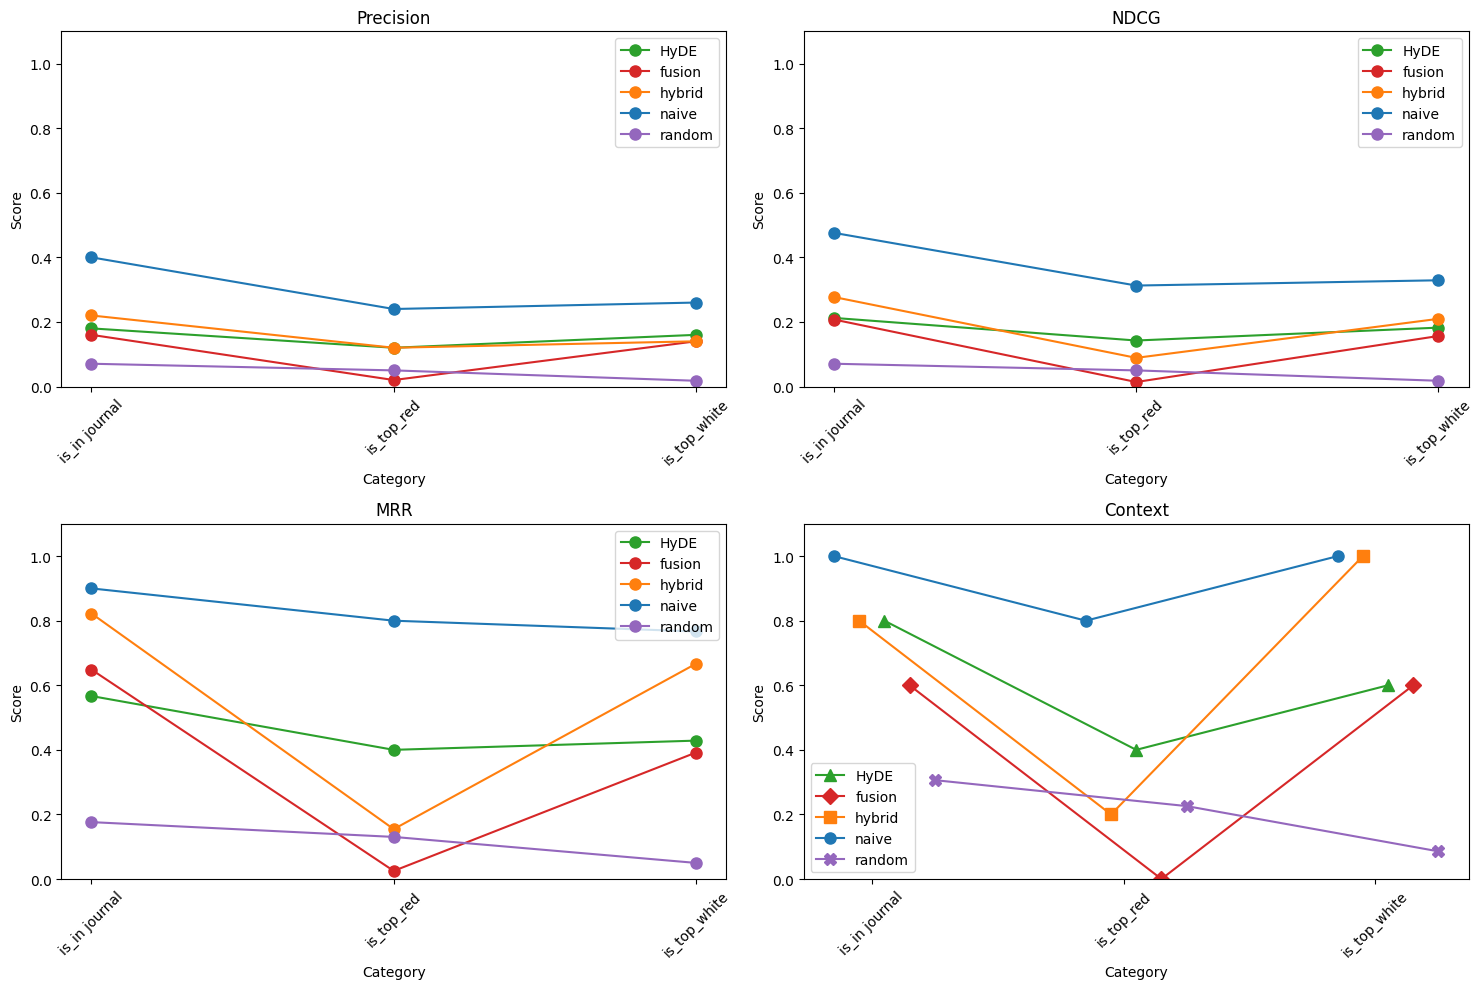

In [ ]:
combined_df_with_random_journal = combined_df_real.copy()

for cat, metric in combined_df_real.columns:
    if cat in avg_metrics_random_journal and metric in avg_metrics_random_journal[cat]:
        combined_df_with_random_journal.loc['random', (cat, metric)] = avg_metrics_random_journal[cat][metric]

combined_df_with_random_journal = combined_df_with_random_journal.sort_index(axis=0)

plot_metrics_df(combined_df_with_random_journal)
plt.show()

# Eval Generation (faithfulness)

## Helping funcs

In [32]:
from langchain.vectorstores import FAISS
from langchain.embeddings import OpenAIEmbeddings

embedding_fn = OpenAIEmbeddings(model="text-embedding-3-large")
vectorstore = FAISS.load_local("/content/faiss_index", embedding_fn, allow_dangerous_deserialization=True) #change_path
print("Loaded FAISS vector store with", vectorstore.index.ntotal, "documents.")

Loaded FAISS vector store with 6312 documents.


In [33]:
def recommend_fusion(query, vectorstore, client, k=5):
    excracted_metadata = extract_metadata(client, query)
    matched_metadata = match_metadata_all(excracted_metadata, allowed_values)
    rewritten_query = rewrite_query_remove_negatives(client, query, excracted_metadata['negative'])

    fusion_queries = generate_queries_llm(client, rewritten_query, 3)
    fusion_queries.append(query)
    fusion_results, query_results, fusion_scores = reciprocal_rank_fusion(vectorstore, fusion_queries, matched_metadata, top_k=k)

    recommendation = get_recommendation(client, fusion_results, query)
    return fusion_results, recommendation

In [34]:
def extract_title_from_content(content):
    match_ = re.search(r"^Title:\s*(.+)$", content, re.MULTILINE)
    return match_.group(1) if match_ else ""

def find_recommended_doc_simple(recommendation_text ,docs):
    def tokenize(text: str) -> set:
        return set(re.findall(r'\w+', text.lower()))

    rec_words = tokenize(recommendation_text)
    best_doc = None
    best_score = 0.0

    for doc in docs:
        content = doc.page_content
        title = extract_title_from_content(content)
        if not title:
            continue
        title_words = tokenize(title)
        overlap = rec_words.intersection(title_words)
        score = len(overlap) / len(title_words)
        if score > best_score:
            best_score = score
            best_doc = doc

    return best_doc


In [75]:
ZS_MODEL = "MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-ling-wanli"
zs_pipeline = pipeline(
    "zero-shot-classification",
    model=ZS_MODEL,
    tokenizer=ZS_MODEL,
    device=0
)

nli_pipeline = pipeline(
    "text-classification",
    model=ZS_MODEL,
    tokenizer=ZS_MODEL,
    return_all_scores=True,
    truncation=True,
    padding=True,
    max_length=512,
    device=0
)

def filter_verifiable_claims(
    sentences,
    threshold,
    verbose):
    verifiable = []
    for s in sentences:
        out = zs_pipeline(
            sequences=[s],
            candidate_labels=["verifiable claim", "commentary"],
            multi_label=False
        )[0]

        score = dict(zip(out["labels"], out["scores"]))["verifiable claim"]
        if verbose:
            print(f"Claim‑detect: {s!r} → {score:.2f}")
        if score >= threshold:
            verifiable.append((s, score))
    return verifiable

def calculate_faithfulness(
    retrieved_doc,
    recommendation,
    zs_threshold=0.1,
    support_threshold=0.5,
    verbose=False):

    sentences = re.split(r'(?<=[.!?])\s+', recommendation.strip())
    verifiable = filter_verifiable_claims(sentences, threshold=zs_threshold, verbose=verbose)
    claims = [c for c, _ in verifiable]
    if not claims:
        return (1.0, []) if verbose else 1.0

    supported = 0
    details=[]

    for claim in claims:
        scores_list = nli_pipeline({
            "text": retrieved_doc,
            "text_pair": claim
        })

        label_scores = {
            entry["label"].upper(): entry["score"]
            for entry in scores_list
        }
        entail_score = label_scores.get("ENTAILMENT", 0.0)
        is_supported = entail_score >= support_threshold

        if verbose:
            print(f"Entail‑check: {claim!r}")
            print(f"  scores: {label_scores}")
            print(f"  supported? {is_supported}\n")

        details.append((claim, label_scores, is_supported))
        if is_supported:
            supported += 1

    faith = supported / len(claims)
    return (faith, details) if verbose else faith

Device set to use cuda:0
Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [76]:
def evaluate_faithfulness_on_queries(queries, vectorstore, client, zs_threshold=0.1, support_threshold=0.5, verbose=True):

    results = []

    for query in tqdm(queries, desc="Evaluating faithfulness"):
        retrieved_documents, recommendation = recommend_fusion(query, vectorstore, client)
        retrieved_doc = find_recommended_doc_simple(recommendation, retrieved_documents)

        faith_score, breakdown = calculate_faithfulness(
            retrieved_doc.page_content,
            recommendation,
            zs_threshold=zs_threshold,
            support_threshold=support_threshold,
            verbose=verbose
        )

        structured_breakdown = []
        for claim, label_scores, supported in breakdown:
            structured_breakdown.append({
                "claim": claim,
                "entailment":    label_scores.get("ENTAILMENT", 0.0),
                "neutral":       label_scores.get("NEUTRAL", 0.0),
                "contradiction": label_scores.get("CONTRADICTION", 0.0),
                "supported":     supported
            })

        results.append({
            "query": query,
            "recommendation": recommendation,
            "retrieved_doc_content": retrieved_doc.page_content,
            "faith_score": faith_score,
            "claim_breakdown": structured_breakdown
        })

    return results

In [77]:
def compute_overall_mean_label_probs(evaluation):
    per_query_avgs = {
        "entailment":    [],
        "neutral":       [],
        "contradiction": []
    }

    for item in evaluation:
        breakdown = item.get("claim_breakdown", [])
        if not breakdown:
            continue
        e_avg = sum(d["entailment"]    for d in breakdown) / len(breakdown)
        n_avg = sum(d["neutral"]       for d in breakdown) / len(breakdown)
        c_avg = sum(d["contradiction"] for d in breakdown) / len(breakdown)
        per_query_avgs["entailment"].append(e_avg)
        per_query_avgs["neutral"].append(n_avg)
        per_query_avgs["contradiction"].append(c_avg)

    overall_means = {}
    for label, vals in per_query_avgs.items():
        overall_means[label] = sum(vals) / len(vals) if vals else 0.0

    return overall_means

In [81]:
query = 'red wine for meat from France under 25'
retrieved_documents, recommendation = recommend_fusion(query, vectorstore, client)

In [82]:
retrieved_doc = find_recommended_doc_simple(recommendation, retrieved_documents)
faith_score, breakdown = calculate_faithfulness(retrieved_doc.page_content, recommendation, verbose=True)

Claim‑detect: 'I highly recommend the **Domaine Laurens 2013 Cuvée de Flars** from Marcillac, priced at **$20**.' → 0.03
Claim‑detect: 'This wonderful red blend of **Fer Servadou and Cabernet Sauvignon** showcases vibrant black fruit flavors harmoniously balanced with firm tannins and bright acidity, making it an excellent companion for hearty meat dishes.' → 0.17
Claim‑detect: 'Rated **89 points**, this wine is aged in wood for 12 months, offering just a subtle hint of smoothness that complements its rich fruitiness.' → 0.23
Claim‑detect: 'It won praise for its good balance and muscular character, without being aggressive—a perfect match for your dining experience.' → 0.02
Claim‑detect: 'With its structured profile and intriguing layers of blackberry, earthy spice, and a peppery finish, this wine stands out as both a value and an impeccable choice for your meal.' → 0.04
Claim‑detect: "Enjoy it now or let it develop further—it's the ideal selection for an elevated mealtime experience."

In [83]:
retrieved_doc.page_content

"Title: Domaine Laurens 2013 Cuvée de Flars  (Marcillac)\nDescription: This wine is a vineyard selection, aged in wood for 12 months. A structured blend of Fer Servadou and Cabernet Sauvignon, it has black fruits, firm tannins and acidity, all in balance. The wood aging is only a hint of smoothness with the rich fruit. Drink from 2018.\nPrice: 20.0, Points: 89, Province: Southwest France, Variety: Red Blend, Designation: Cuvée de Flars, Country: France, Region_1: Marcillac, Winery: Domaine Laurens, Vintage: 2013, Wine Color: Red\nReviews:\n('Tasty and affordable—this wine offers real bang for your buck.', 5.0)\n('Vibrant black-currant with nuance of jammy red fruit, earthy spice; carefully oaked vanilla with hint of coffee, peppery on the finish. Good balance, quite muscular without being agressive. Great value. 2016 drinking well now if aired for an hour or two.', 4.0)\n('Small French wine very well vinified. Nose if full of blackberry. Tanins are round and pleasant almost oily. Explo

In [84]:
recommendation

"I highly recommend the **Domaine Laurens 2013 Cuvée de Flars** from Marcillac, priced at **$20**. This wonderful red blend of **Fer Servadou and Cabernet Sauvignon** showcases vibrant black fruit flavors harmoniously balanced with firm tannins and bright acidity, making it an excellent companion for hearty meat dishes. Rated **89 points**, this wine is aged in wood for 12 months, offering just a subtle hint of smoothness that complements its rich fruitiness. It won praise for its good balance and muscular character, without being aggressive—a perfect match for your dining experience. With its structured profile and intriguing layers of blackberry, earthy spice, and a peppery finish, this wine stands out as both a value and an impeccable choice for your meal. Enjoy it now or let it develop further—it's the ideal selection for an elevated mealtime experience."

In [85]:
print(f"Faithfulness: {faith_score:.2f}\n")
for claim, label_scores, ok in breakdown:
    print(f"Claim: {claim}")
    print("Scores:")
    for label, sc in label_scores.items():
        print(f"  {label}: {sc:.2f}")
    print(f"Supported: {ok}\n")

Faithfulness: 1.00

Claim: This wonderful red blend of **Fer Servadou and Cabernet Sauvignon** showcases vibrant black fruit flavors harmoniously balanced with firm tannins and bright acidity, making it an excellent companion for hearty meat dishes.
Scores:
  ENTAILMENT: 0.86
  NEUTRAL: 0.12
  CONTRADICTION: 0.02
Supported: True

Claim: Rated **89 points**, this wine is aged in wood for 12 months, offering just a subtle hint of smoothness that complements its rich fruitiness.
Scores:
  ENTAILMENT: 1.00
  NEUTRAL: 0.00
  CONTRADICTION: 0.00
Supported: True


##Faithfullness eval


In [86]:
# mostly AI ganerated
test_queries = [
    "Recommend a US Cabernet Sauvignon under $30 with at least 90 points.",
    "Find a US Pinot Noir above 92 points to pair with salmon.",
    "Suggest a US Chardonnay under $25 with citrus notes.",
    "Recommend a US Zinfandel with pepper notes and 90+ points.",
    "Find a US Syrah under $40 that pairs with lamb.",
    "Suggest a US Merlot above 88 points and dark fruit flavours.",
    "Recommend a US Sauvignon Blanc under $20 with tropical aromas.",
    "Find a US sparkling wine above 91 points for celebrations.",
    "Suggest a US one under $30 with stone fruit flavours.",
    "Recommend a US Riesling above 90 points to pair with spicy food.",
    "Find a US Malbec under $35 with blackberry aromas.",
    "Suggest a US Petite Sirah above 89 points.",
    "Recommend a US under $25 with honeyed notes.",
    "Find a US Blanc under $30 with cherry flavours.",
    "Suggest a US under $35 with earthy notes.",
    "Recommend a US Cabernet Franc above 88 points.",
    "Find a US Mourvèdre under $40 for a hearty stew.",
    "Suggest a US Chenin Blanc under $25 with floral aromas.",
    "Recommend a US Sparkling Brut under $45 for an anniversary.",
    "Find a US Petit Verdot above 90 points.",
    "Suggest a US Rosé under $20 with watermelon notes.",
    "Recommend a US Colombard under $15 with crisp acidity.",
    "Find a US Barbera under $30 with cherry flavours.",
    "Recommend an Italian under $60 with 92+ points.",
    "Find an Italian Nebbiolo above 90 points to pair with truffle pasta.",
    "Suggest an Italian Chianti Classico under $30 with cherry notes.",
    "Recommend an Italian Brunello di Montalcino above 93 points.",
    "Find an Italian Prosecco under $25 for aperitivo.",
    "Suggest an Italian under one $20 with almond aromas.",
    "Recommend an Italian one under $50 with raisin flavours.",
    "Find an Italian above 89 points.",
    "Suggest an Italian Pinot Noir under $20 with green apple notes.",
    "Recommend an Italian Dolcetto under $30 with youthful tannins.",
    "Recommend a Spanish one under $30 with 90+ points.",
    "Find a Spanish Blanc above 92 points to pair with seafood.",
    "Suggest a Spanish under $25 with cherry flavours.",
    "Recommend a Spanish Reserve above 90 points.",
    "Find a Spanish Verdejo under $20 with herbaceous notes.",
    "Suggest a Spanish above 91 points for brunch.",
    "Recommend a Spanish under $35 with a spicy finish.",
    "Find a Spanish Priorat above 93 points.",
    "Recommend an Argentinian Malbec under $30 with 90+ points.",
    "Find an Argentinian above 88 points to pair with ceviche.",
    "Suggest an Argentinian Cabernet Sauvignon under $35 with pepper notes.",
    "Recommend an Argentinian above 87 points.",
    "Recommend an Australian under $30 with 91+ points.",
    "Find an Australian Cabernet Sauvignon above 90 points to pair with barbecue.",
    "Suggest an Australian Riesling under $20 with citrus notes.",
    "Recommend a Moldovan Purcari under $25 with 88+ points.",
    "Find a Moldovan red above 90 points for a meat pairing."
]

In [87]:
evaluation = evaluate_faithfulness_on_queries(
    test_queries,
    vectorstore,
    client,
    zs_threshold=0.1,
    support_threshold=0.5,
    verbose=True
)

Evaluating faithfulness:   0%|          | 0/50 [00:00<?, ?it/s]

Claim‑detect: 'I highly recommend the **Chateau Ste.' → 0.08
Claim‑detect: "Michelle 2010 Canoe Ridge Estate Cabernet Sauvignon**, a standout from Washington's Horse Heaven Hills region." → 0.56
Claim‑detect: 'Priced at just $30, this exquisite wine boasts an impressive rating of 90 points and is crafted from 95% Cabernet Sauvignon, complemented by blends of Merlot, Syrah, and Malbec.' → 0.05
Claim‑detect: 'The tasting experience opens with enticing notes of char, roasted coffee bean, and lush cherry, while the palate reveals a rich, chocolaty profile that’s seamlessly stitched together.' → 0.11
Claim‑detect: "This wine's accessibility makes it a great choice for both everyday enjoyment and special occasions." → 0.14
Claim‑detect: 'Its harmonious balance of flavors and elegant finish ensure that it not only meets but exceeds expectations for a superb Cabernet Sauvignon under $30.' → 0.15
Entail‑check: "Michelle 2010 Canoe Ridge Estate Cabernet Sauvignon**, a standout from Washington's 

Evaluating faithfulness:   2%|▏         | 1/50 [00:10<08:48, 10.79s/it]

Entail‑check: "This wine's accessibility makes it a great choice for both everyday enjoyment and special occasions."
  scores: {'ENTAILMENT': 0.0033805002458393574, 'NEUTRAL': 0.9964330196380615, 'CONTRADICTION': 0.00018647410615812987}
  supported? False

Entail‑check: 'Its harmonious balance of flavors and elegant finish ensure that it not only meets but exceeds expectations for a superb Cabernet Sauvignon under $30.'
  scores: {'ENTAILMENT': 0.9926431775093079, 'NEUTRAL': 0.006816850509494543, 'CONTRADICTION': 0.0005399019573815167}
  supported? True

Claim‑detect: 'I highly recommend the **J.' → 0.08
Claim‑detect: 'Christopher 2012 Lumière Pinot Noir** from the Eola-Amity Hills in Oregon, priced at **$39.00**.' → 0.44
Claim‑detect: 'This exquisite wine boasts a strong rating of **92 points** and embodies the aromatic sophistication that complements salmon beautifully.' → 0.19
Claim‑detect: 'On the palate, it showcases bright raspberry fruit interspersed with peppery herbs and a lon

Evaluating faithfulness:   4%|▍         | 2/50 [00:21<08:22, 10.48s/it]

Entail‑check: 'On the palate, it showcases bright raspberry fruit interspersed with peppery herbs and a long, earthy finish, making it a delightful match for roasted salmon.'
  scores: {'ENTAILMENT': 0.995296061038971, 'NEUTRAL': 0.004456465598195791, 'CONTRADICTION': 0.0002475302026141435}
  supported? True

Entail‑check: 'With its elegant structure, this Pinot Noir is a refined choice that effortlessly elevates your dining occasion.'
  scores: {'ENTAILMENT': 0.9483927488327026, 'NEUTRAL': 0.05011945962905884, 'CONTRADICTION': 0.0014877229696139693}
  supported? True

Claim‑detect: 'I highly recommend the **Saracina 2015 Unoaked Chardonnay** from Mendocino County, California, priced at just **$18**.' → 0.04
Claim‑detect: 'This fresh and vibrant white wine boasts **91 points**, making it a notable selection for quality seekers.' → 0.10
Claim‑detect: 'The Saracina Chardonnay stands out for its delightful citrus notes, complemented by refreshing acidity and subtle hints of apple and spic

Evaluating faithfulness:   6%|▌         | 3/50 [00:30<07:57, 10.15s/it]

Entail‑check: 'If you’re searching for a well-crafted, affordable Chardonnay with bright citrus flair, this bottle is undoubtedly your best choice.'
  scores: {'ENTAILMENT': 0.11604471504688263, 'NEUTRAL': 0.8813081383705139, 'CONTRADICTION': 0.00264714821241796}
  supported? False

Claim‑detect: 'I highly recommend the **Dry Creek Vineyard 2013 Old Vine Zinfandel** from Dry Creek Valley, California, priced at **$32.00**.' → 0.04
Claim‑detect: 'With an impressive rating of **93 points**, this Zinfandel exemplifies the quality of old vine fruit, sourced from vines averaging 95 years old.' → 0.27
Claim‑detect: "As you indulge in this wine, you'll encounter a beautiful balance of savory peppercorn and espresso overtones, beautifully intertwined with a ripe, juicy core of blackberry." → 0.16
Claim‑detect: "The wine's supportive acidity provides freshness, ensuring a lengthy and satisfying finish that lingers." → 0.24
Claim‑detect: 'This vintage not only showcases complex flavors but also a

Evaluating faithfulness:   8%|▊         | 4/50 [00:42<08:08, 10.61s/it]

Entail‑check: "As you indulge in this wine, you'll encounter a beautiful balance of savory peppercorn and espresso overtones, beautifully intertwined with a ripe, juicy core of blackberry."
  scores: {'ENTAILMENT': 0.9961410164833069, 'NEUTRAL': 0.003402506234124303, 'CONTRADICTION': 0.00045647865044884384}
  supported? True

Entail‑check: "The wine's supportive acidity provides freshness, ensuring a lengthy and satisfying finish that lingers."
  scores: {'ENTAILMENT': 0.5222664475440979, 'NEUTRAL': 0.4755769371986389, 'CONTRADICTION': 0.0021566615905612707}
  supported? True

Claim‑detect: 'I highly recommend the **Scott Harvey 2012 Mountain Selection Syrah** from Amador County, priced at an affordable **$24**.' → 0.05
Claim‑detect: 'This captivating Californian Syrah sports a **91-point** rating, showcasing rich flavors of **blackberry**, **boysenberry**, and intriguing hints of **smoke** and **grilled meat**—perfect for pairing with lamb.' → 0.10
Claim‑detect: 'Its medium to full-bo

Evaluating faithfulness:  10%|█         | 5/50 [00:52<07:51, 10.47s/it]

Entail‑check: 'This wine’s well-balanced flavor profile ensures a delightful accompaniment to the rich, gamey taste of lamb, enhancing your dining experience beautifully.'
  scores: {'ENTAILMENT': 0.0005292894202284515, 'NEUTRAL': 0.9989063739776611, 'CONTRADICTION': 0.0005642558680847287}
  supported? False

Entail‑check: 'With its complexity and approachable price, this bottle is an ideal choice for your meal.'
  scores: {'ENTAILMENT': 0.01280278991907835, 'NEUTRAL': 0.9847754836082458, 'CONTRADICTION': 0.002421787241473794}
  supported? False

Claim‑detect: 'I highly recommend the **Monticello Vineyards 2011 Estate Merlot** from the Oak Knoll District in California, which boasts an impressive **92 points** rating and is priced at **$35**.' → 0.01
Claim‑detect: 'This exquisite red offers an extraordinarily intriguing bouquet, showcasing aromas of turned earth, black olive, and concentrated strawberry, all complemented by touches of sagebrush and tarragon on the palate.' → 0.22
Claim‑

Evaluating faithfulness:  12%|█▏        | 6/50 [01:00<07:08,  9.74s/it]

Entail‑check: "As it unfolds, you'll find dense yet elegantly presented flavors of blueberry and black cherry, delivering a harmonious balance that enthralls the senses."
  scores: {'ENTAILMENT': 0.9987362027168274, 'NEUTRAL': 0.0010088146664202213, 'CONTRADICTION': 0.0002549850905779749}
  supported? True

Claim‑detect: 'I highly recommend the Alysian 2014 Grist Vineyard Sauvignon Blanc from Dry Creek Valley, California, priced at an approachable $20.' → 0.02
Claim‑detect: 'This vibrant wine, earning an impressive 91 points, showcases delightful tropical aromas, particularly the notes of grapefruit and hints of pineapple that dance across the palate.' → 0.34
Claim‑detect: 'With part of the fermentation done in neutral French oak, it provides a light yet refreshingly crisp texture that is well balanced with lively acidity.' → 0.09
Claim‑detect: 'This Sauvignon Blanc is ideal for enjoying in the sun or pairing with your favorite light dishes, aligning perfectly with your desire for a US

Evaluating faithfulness:  14%|█▍        | 7/50 [01:13<07:43, 10.78s/it]

Entail‑check: 'This vibrant wine, earning an impressive 91 points, showcases delightful tropical aromas, particularly the notes of grapefruit and hints of pineapple that dance across the palate.'
  scores: {'ENTAILMENT': 0.996070146560669, 'NEUTRAL': 0.0021728789433836937, 'CONTRADICTION': 0.0017569981282576919}
  supported? True

Entail‑check: 'This Sauvignon Blanc is ideal for enjoying in the sun or pairing with your favorite light dishes, aligning perfectly with your desire for a US wine under $20 that offers enticing tropical notes.'
  scores: {'ENTAILMENT': 0.9895268678665161, 'NEUTRAL': 0.008683202788233757, 'CONTRADICTION': 0.0017898946534842253}
  supported? True

Claim‑detect: 'For your celebratory occasion, I recommend the exquisite **Brewer-Clifton 2011 3D Sparkling Chardonnay** from the picturesque Sta.' → 0.14
Claim‑detect: 'Rita Hills in California.' → 0.50
Claim‑detect: 'Priced at $68, this beautifully golden-hued sparkler has garnered an impressive **91 points** for its

Evaluating faithfulness:  16%|█▌        | 8/50 [01:22<07:07, 10.18s/it]

Entail‑check: 'With enticing aromas of yellow flowers, fresh-picked pears, and pressed apples, it tantalizes the senses before delivering an explosive palate of bright lemon zest and a delightful cooked apple soda finish.'
  scores: {'ENTAILMENT': 0.9878525733947754, 'NEUTRAL': 0.009170964360237122, 'CONTRADICTION': 0.0029764422215521336}
  supported? True

Claim‑detect: 'I recommend the Foris 2010 Frizzante Muscat from Rogue Valley, Oregon, priced at an attractive $14.' → 0.04
Claim‑detect: 'This delightful wine boasts an enticing blend of flavors that resembles a lovely orange perfume, complemented by hints of peach and apricot that embody a lush stone fruit character.' → 0.10
Claim‑detect: 'With a light alcohol content of 7.2% and a playful effervescence, this medium-sweet wine is perfect for both after-dinner enjoyment or as a refreshing companion on a warm summer evening.' → 0.04
Claim‑detect: 'Garnering an impressive score of 88 points, the Frizzante Muscat is a well-balanced cho

Evaluating faithfulness:  18%|█▊        | 9/50 [01:30<06:25,  9.40s/it]

Entail‑check: 'It perfectly aligns with your request for a U.S.'
  scores: {'ENTAILMENT': 0.011750618927180767, 'NEUTRAL': 0.9864425659179688, 'CONTRADICTION': 0.0018067911732941866}
  supported? False

Entail‑check: 'wine under $30, ensuring a delightful experience without breaking the bank.'
  scores: {'ENTAILMENT': 0.9598998427391052, 'NEUTRAL': 0.037134524434804916, 'CONTRADICTION': 0.002965709427371621}
  supported? True

Claim‑detect: 'I highly recommend the Boundary Breaks 2011 No.' → 0.09
Claim‑detect: '198 Reserve Riesling from the Finger Lakes, priced at $25.' → 0.65
Claim‑detect: 'This exquisite wine boasts an impressive rating of 90 points and offers a beautifully concentrated palate bursting with ripe peach and tangerine flavors.' → 0.34
Claim‑detect: 'Its vibrant acidity is perfectly balanced with a touch of sweetness, making it refreshingly brisk and bright.' → 0.13
Claim‑detect: "The wine's elegant finish is enhanced by hints of jasmine tea and honey, providing a deligh

Evaluating faithfulness:  20%|██        | 10/50 [01:41<06:39,  9.99s/it]

Entail‑check: "The wine's elegant finish is enhanced by hints of jasmine tea and honey, providing a delightful complexity."
  scores: {'ENTAILMENT': 0.24367809295654297, 'NEUTRAL': 0.7548708319664001, 'CONTRADICTION': 0.0014510799665004015}
  supported? False

Claim‑detect: 'I highly recommend the **Galante 2012 Ace High Malbec** from **Carmel Valley, California**, priced at **$32.00**.' → 0.03
Claim‑detect: 'This exquisite wine received **88 points** and showcases an intriguing bouquet of smoke, leather, cedar, and dried red cherry, complemented by herbal spice.' → 0.28
Claim‑detect: "On the palate, you'll discover vibrant acidity alongside stiff tannins that reveal delightful flavors of **blackberry**, dark cherry, and cranberry, all enhanced by hints of dill and pepper." → 0.22
Claim‑detect: 'With a well-rounded profile that refreshes the palate, this Malbec is both complex and approachable, making it an ideal choice under $35 for those seeking a wine with rich fruit aromas, especia

Evaluating faithfulness:  22%|██▏       | 11/50 [01:51<06:25,  9.89s/it]

Entail‑check: "On the palate, you'll discover vibrant acidity alongside stiff tannins that reveal delightful flavors of **blackberry**, dark cherry, and cranberry, all enhanced by hints of dill and pepper."
  scores: {'ENTAILMENT': 0.9607025980949402, 'NEUTRAL': 0.0339667983353138, 'CONTRADICTION': 0.00533065851777792}
  supported? True

Entail‑check: 'Its balance and structure also suggest a promising future with a bit of aging, thereby making it a stellar match for your needs.'
  scores: {'ENTAILMENT': 0.538871705532074, 'NEUTRAL': 0.4597017168998718, 'CONTRADICTION': 0.0014265747740864754}
  supported? True

Claim‑detect: 'I highly recommend the **Sirius 2010 Eaglepoint Ranch Petite Sirah** from Mendocino County, a stunning wine that elegantly embodies the richness and complexity of its variety.' → 0.01
Claim‑detect: 'Priced at $45, this PETITE SIRAH has earned an impressive rating of 94 points, making it a standout choice for connoisseurs.' → 0.10
Claim‑detect: 'Upon pouring, you’l

Evaluating faithfulness:  24%|██▍       | 12/50 [02:01<06:16,  9.92s/it]

Entail‑check: 'This wine not only meets your desire for a highly-rated Petite Sirah but also offers a unique sensory experience that sets it apart from the rest.'
  scores: {'ENTAILMENT': 0.9909682869911194, 'NEUTRAL': 0.007758315186947584, 'CONTRADICTION': 0.0012733078328892589}
  supported? True

Claim‑detect: "I highly recommend the Beringer 2015 Founders' Estate Cabernet Sauvignon, priced at an incredible $10." → 0.05
Claim‑detect: 'This well-crafted wine from California boasts an impressive rating of 88 points and offers a unique tasting experience that features juicy notes of raspberries and cherries, complemented by a savory hint of meatiness that adds complexity.' → 0.16
Claim‑detect: 'While it’s not explicitly honeyed, the rich fruit character and moderate tannins provide a smooth, satisfying mouthfeel akin to the sweetness you might associate with honeyed notes.' → 0.10


Evaluating faithfulness:  26%|██▌       | 13/50 [02:09<05:48,  9.42s/it]

Claim‑detect: 'Its sturdy structure makes it an excellent companion for hearty dishes, ensuring it will impress at your next dinner gathering.' → 0.10
Claim‑detect: 'This wine is perfect not only for its approachability and value, but also for its delightful flavor profile, making it an ideal choice while staying under your budget of $25.' → 0.05
Entail‑check: 'This well-crafted wine from California boasts an impressive rating of 88 points and offers a unique tasting experience that features juicy notes of raspberries and cherries, complemented by a savory hint of meatiness that adds complexity.'
  scores: {'ENTAILMENT': 0.998059093952179, 'NEUTRAL': 0.0015624125953763723, 'CONTRADICTION': 0.0003784119035117328}
  supported? True

Claim‑detect: "I highly recommend the **Beringer 2016 Founders' Estate Sauvignon Blanc** from California, priced at a remarkable $10." → 0.02
Claim‑detect: 'With a solid rating of 88 points, this wine showcases a full-bodied and rounded texture that is quite 

Evaluating faithfulness:  28%|██▊       | 14/50 [02:17<05:24,  9.02s/it]

Entail‑check: 'This excellent value wine beautifully aligns with your desire for a US Blanc under $30 while offering a complexity and richness that elevates it beyond its price point, making it a fantastic choice for your palate.'
  scores: {'ENTAILMENT': 0.9508352279663086, 'NEUTRAL': 0.04650593921542168, 'CONTRADICTION': 0.0026588034816086292}
  supported? True

Claim‑detect: 'I highly recommend the **Bogle 2014 Essential Red**, which beautifully fits your criteria at an incredible price of **$12.00**.' → 0.09
Claim‑detect: 'This exquisite red blend from California, rated **90 points**, boasts a rich tapestry of flavors, including focused notes of cranberry and black cherry, layered with enchanting undertones of vanilla and earthy nuances.' → 0.23
Claim‑detect: 'Its full-bodied nature offers a sleek texture, allowing for a mouthfilling experience that lingers with a lightly sweet finish, making it a compelling choice for both casual sipping and pairing with barbeque or hearty pasta d

Evaluating faithfulness:  30%|███       | 15/50 [02:24<04:54,  8.40s/it]

Claim‑detect: 'With such complexity and richness, this wine showcases how an affordable bottle can deliver premium quality, making it the ideal option for an earthy wine lover like yourself.' → 0.09
Entail‑check: 'This exquisite red blend from California, rated **90 points**, boasts a rich tapestry of flavors, including focused notes of cranberry and black cherry, layered with enchanting undertones of vanilla and earthy nuances.'
  scores: {'ENTAILMENT': 0.9961556792259216, 'NEUTRAL': 0.002916360041126609, 'CONTRADICTION': 0.0009279100922867656}
  supported? True

Claim‑detect: 'I highly recommend the **Hermann J.' → 0.10
Claim‑detect: 'Wiemer 2012 Magdalena Vineyard Cabernet Franc** from the picturesque Seneca Lake region of New York.' → 0.63
Claim‑detect: 'Priced at a very reasonable **$32**, this exquisite wine has achieved an impressive **94 points**, setting a benchmark for American red wines.' → 0.10
Claim‑detect: 'The 2012 vintage beautifully showcases the unique terroir of the 

Evaluating faithfulness:  32%|███▏      | 16/50 [02:33<04:47,  8.45s/it]

Entail‑check: 'Wiemer 2012 Magdalena Vineyard Cabernet Franc** from the picturesque Seneca Lake region of New York.'
  scores: {'ENTAILMENT': 0.7548323273658752, 'NEUTRAL': 0.23431958258152008, 'CONTRADICTION': 0.010848075151443481}
  supported? True

Entail‑check: 'The 2012 vintage beautifully showcases the unique terroir of the Finger Lakes, often celebrated for its Riesling, yet this Cabernet Franc stands out for its complexity and elegance.'
  scores: {'ENTAILMENT': 0.9950410723686218, 'NEUTRAL': 0.0046825772151350975, 'CONTRADICTION': 0.0002763552183751017}
  supported? True

Claim‑detect: 'For your hearty stew, I highly recommend the D.H.' → 0.07
Claim‑detect: 'Lescombes 2007 Limited Release Mourvèdre from New Mexico.' → 0.49
Claim‑detect: 'Priced at just $24, this elegant red offers an inviting and soulful profile that includes alluring aromas of blackberry and spice, complemented by mouthfilling flavors of rich blackberry and sweet vanilla toast.' → 0.08
Claim‑detect: 'With an 

Evaluating faithfulness:  34%|███▍      | 17/50 [02:42<04:46,  8.67s/it]

Entail‑check: 'Lescombes 2007 Limited Release Mourvèdre from New Mexico.'
  scores: {'ENTAILMENT': 0.9995986819267273, 'NEUTRAL': 0.00023541395785287023, 'CONTRADICTION': 0.00016590412997175008}
  supported? True

Entail‑check: 'With an impressive rating of 84 points, this limited release Mourvèdre embodies a soft yet lingering texture, making it a fantastic, food-friendly choice.'
  scores: {'ENTAILMENT': 0.9963080883026123, 'NEUTRAL': 0.003416280262172222, 'CONTRADICTION': 0.0002756640315055847}
  supported? True

Entail‑check: "It's a perfect partner for your meal without breaking the bank."
  scores: {'ENTAILMENT': 0.17813050746917725, 'NEUTRAL': 0.8205773234367371, 'CONTRADICTION': 0.0012921508168801665}
  supported? False

Claim‑detect: 'I highly recommend the **Graziano 2014 Dry Chenin Blanc** from Mendocino County, priced at just **$15**.' → 0.03
Claim‑detect: 'This delightful wine not only falls under your budget of $25, but it also boasts beautifully expressive **floral** and

Evaluating faithfulness:  36%|███▌      | 18/50 [02:52<04:49,  9.04s/it]

Entail‑check: 'This medium-bodied Chenin Blanc is refreshingly dry, making it an excellent choice for various occasions, from picnics to elegant dinners.'
  scores: {'ENTAILMENT': 0.040119271725416183, 'NEUTRAL': 0.9596381783485413, 'CONTRADICTION': 0.0002425124985165894}
  supported? False

Claim‑detect: 'For your anniversary celebration, I highly recommend the **Mumm Napa 2009 Devaux Ranch Sparkling**, which beautifully exemplifies the elegance and depth you’re seeking in a sparkling wine.' → 0.01
Claim‑detect: 'Priced at a reasonable **$42**, this exquisite California wine from the renowned Napa Valley boasts an impressive **92 points** rating.' → 0.10
Claim‑detect: 'The 2009 vintage perfectly showcases layers of fresh-baked brioche and enchanting orange blossom notes, leading to a long and lingering finish that will make your special moment truly memorable.' → 0.32
Claim‑detect: 'Its golden yellow hue indicates its careful aging and complexity, making it an ideal choice for a roman

Evaluating faithfulness:  38%|███▊      | 19/50 [03:00<04:37,  8.95s/it]

Entail‑check: 'This small-production gem not only offers a savory and dry profile but also a sublime sensory experience that is bound to enhance your anniversary celebration.'
  scores: {'ENTAILMENT': 0.12414973974227905, 'NEUTRAL': 0.869065523147583, 'CONTRADICTION': 0.006784670986235142}
  supported? False

Entail‑check: 'Cheers to love and fine wine!'
  scores: {'ENTAILMENT': 0.02636781521141529, 'NEUTRAL': 0.9727004766464233, 'CONTRADICTION': 0.0009317255462519825}
  supported? False

Claim‑detect: 'I highly recommend the **Côtes de Ciel 2012 Ciel du Cheval Vineyard Petit Verdot** from Washington, which stands out with an impressive rating of **93 points**.' → 0.01
Claim‑detect: 'Priced at **$39**, this wine showcases the quintessential profile of pure Petit Verdot, offering an enticing blend of ripe fig and plum fruits complemented by a delightful salinity.' → 0.17
Claim‑detect: 'Its big, tannic structure ensures a rich mouthfeel, while the beautifully integrated high alcohol cont

Evaluating faithfulness:  40%|████      | 20/50 [03:13<04:59,  9.97s/it]

Entail‑check: 'Its big, tannic structure ensures a rich mouthfeel, while the beautifully integrated high alcohol content rounds out the experience for a persistent finish that lingers pleasantly.'
  scores: {'ENTAILMENT': 0.632162868976593, 'NEUTRAL': 0.36245498061180115, 'CONTRADICTION': 0.005382182076573372}
  supported? True

Entail‑check: "If you're looking for a powerful yet elegant Petit Verdot that truly exemplifies its varietal character, this bottle will not disappoint."
  scores: {'ENTAILMENT': 0.9949116110801697, 'NEUTRAL': 0.004856158047914505, 'CONTRADICTION': 0.0002322491491213441}
  supported? True

Claim‑detect: 'I highly recommend the Andis 2015 Estate Rosé from Amador County, California, which is an exceptional pick at just $18.' → 0.01
Claim‑detect: 'This delightful rosé features a light pink hue and offers a fresh and zesty aroma, with flavors that highlight watermelon alongside a hint of grapefruit and ripe cherries.' → 0.27
Claim‑detect: 'Scoring an impressive 88 

Evaluating faithfulness:  42%|████▏     | 21/50 [03:23<04:54, 10.17s/it]

Entail‑check: 'With its charming fruit profile and approachable price point, this rosé perfectly meets your desire for a delightful wine that showcases watermelon notes and remains under $20.'
  scores: {'ENTAILMENT': 0.9874446392059326, 'NEUTRAL': 0.010963359847664833, 'CONTRADICTION': 0.0015919822035357356}
  supported? True

Claim‑detect: 'I highly recommend the Y Rousseau 2013 Old Vines Colombard from the Russian River Valley.' → 0.05
Claim‑detect: 'Priced at just $20 (still under your budget if you can stretch a little), this wine boasts an impressive score of 88 points, making it a superb choice.' → 0.05
Claim‑detect: 'It showcases vibrant flavors of pineapple, pear, and exotic lemongrass, creating a delightful freshness that is both textured and enjoyable.' → 0.29
Claim‑detect: 'The crisp acidity combined with a steely finish makes it an ideal companion for a variety of dishes or simply enjoyed on its own.' → 0.10
Claim‑detect: 'This Colombard stands out not only for its delicio

Evaluating faithfulness:  44%|████▍     | 22/50 [03:33<04:42, 10.11s/it]

Entail‑check: "If you're looking for a crisp, refreshing white with great value, this bottle perfectly meets your desires."
  scores: {'ENTAILMENT': 0.9723184108734131, 'NEUTRAL': 0.02726030722260475, 'CONTRADICTION': 0.00042129537905566394}
  supported? True

Claim‑detect: 'I highly recommend the **Montevina 2013 Skyland Ridge Barbera** from Amador County, priced at just **$10**.' → 0.05
Claim‑detect: 'This delightful wine offers a captivating bouquet of wild berries and light baking spices, making it aromatic and inviting.' → 0.17
Claim‑detect: 'On the palate, it presents almost jammy cherry flavors that beautifully balance with a smooth, dry finish, creating a plush mouthfeel.' → 0.19
Claim‑detect: 'With an impressive rating of **89 points**, this medium-bodied red is not only easy to enjoy on its own, but it also pairs splendidly with a variety of dishes, including sushi.' → 0.05
Claim‑detect: 'Given its affordable price point and lush cherry notes, the Montevina Barbera perfectly 

Evaluating faithfulness:  46%|████▌     | 23/50 [03:45<04:42, 10.45s/it]

Entail‑check: 'On the palate, it presents almost jammy cherry flavors that beautifully balance with a smooth, dry finish, creating a plush mouthfeel.'
  scores: {'ENTAILMENT': 0.3538883924484253, 'NEUTRAL': 0.6410673260688782, 'CONTRADICTION': 0.005044248420745134}
  supported? False

Claim‑detect: 'I highly recommend the Francesco Rinaldi 2012 Brunate Barolo, an exquisite red from the renowned Piedmont region of Italy, priced at $60 and boasting an impressive rating of 92 points.' → 0.00
Claim‑detect: 'This structured Nebbiolo presents a captivating bouquet of berry, eucalyptus, and Alpine herbs, while the palate reveals juicy Morello cherry, crushed raspberry, and subtle cooking spices, all balanced by firm yet refined tannins.' → 0.29
Claim‑detect: 'With a drinking window from 2020 to 2032, this wine not only showcases the complexity and elegance characteristic of Barolo but also offers an exceptional value for an iconic Italian vintage.' → 0.04
Claim‑detect: 'Its harmonious blend o

Evaluating faithfulness:  48%|████▊     | 24/50 [03:52<04:10,  9.63s/it]

Entail‑check: 'Its harmonious blend of flavors makes it a perfect match for your criteria of excellence without breaking the bank, ensuring a memorable experience with each sip.'
  scores: {'ENTAILMENT': 0.10728861391544342, 'NEUTRAL': 0.8862695097923279, 'CONTRADICTION': 0.006441917736083269}
  supported? False

Claim‑detect: 'For a delightful pairing with truffle pasta, I highly recommend the **Cantina del Nebbiolo 2011 Cannubi Boschis** from Barolo, Italy.' → 0.01
Claim‑detect: 'Priced at $70, this wine has garnered an impressive rating of 90 points.' → 0.24
Claim‑detect: 'It boasts an alluring bouquet of leafy underbrush, truffle, and woodland berry aromas, making it an ideal match for your dish.' → 0.12
Claim‑detect: 'On the palate, you’ll find a robust profile featuring ripe black cherry, crushed raspberry, and grilled sage, rounded out by grounding notes of aniseed.' → 0.18
Claim‑detect: 'The assertive tannins and bright acidity ensure it has a chewyness that balances beautifull

Evaluating faithfulness:  50%|█████     | 25/50 [04:05<04:22, 10.48s/it]

Entail‑check: 'The assertive tannins and bright acidity ensure it has a chewyness that balances beautifully with luxurious pasta dishes, especially those with truffle.'
  scores: {'ENTAILMENT': 0.03598206117749214, 'NEUTRAL': 0.9569603204727173, 'CONTRADICTION': 0.007057622540742159}
  supported? False

Entail‑check: 'Since it is recommended for drinking from 2018 to 2028, you are certainly in for a treat with this exquisite 2011 vintage that exemplifies the best of Nebbiolo.'
  scores: {'ENTAILMENT': 0.9867373108863831, 'NEUTRAL': 0.012822865508496761, 'CONTRADICTION': 0.00043984700459986925}
  supported? True

Claim‑detect: 'I recommend the Gagliole 2013 Rubiolo, an exceptional Chianti Classico that perfectly fits your criteria at just $20.' → 0.08
Claim‑detect: 'Hailing from the renowned Tuscany region of Italy, this delightful red blend, composed of 90% Sangiovese and 10% Merlot, showcases inviting aromas of underbrush, truffle, and black plum, punctuated by a subtle hint of toast.

Evaluating faithfulness:  52%|█████▏    | 26/50 [04:14<04:02, 10.10s/it]

Entail‑check: 'Enjoy this gem soon for an authentic taste of Tuscany!'
  scores: {'ENTAILMENT': 0.007170272991061211, 'NEUTRAL': 0.9924708604812622, 'CONTRADICTION': 0.00035882729571312666}
  supported? False

Claim‑detect: 'I highly recommend the **Il Palazzone 2010 Riserva**, a magnificent example of Brunello di Montalcino that boasts an impressive score of **95 points**.' → 0.02
Claim‑detect: "Priced at **$170**, this wine from **Italy's Tuscany region** is a true embodiment of the Sangiovese variety." → 0.21
Claim‑detect: "On the nose, you'll be enveloped by enticing scents of ripe dark-skinned berries, leafy underbrush, chopped herb, and dark spice, leading to a palate that is both delicious and complex." → 0.02
Claim‑detect: 'It reveals layers of juicy black cherry, crushed raspberry, and a hint of orange peel, all polished by firm, velvety tannins.' → 0.52
Claim‑detect: "The wine's finish is gracefully rounded off with a subtle coffee note, making it an exquisite choice for both

Evaluating faithfulness:  54%|█████▍    | 27/50 [04:28<04:17, 11.20s/it]

Entail‑check: "The wine's finish is gracefully rounded off with a subtle coffee note, making it an exquisite choice for both savoring on its own and pairing with rich dishes."
  scores: {'ENTAILMENT': 0.9921600222587585, 'NEUTRAL': 0.0074147554114460945, 'CONTRADICTION': 0.00042525611934252083}
  supported? True

Claim‑detect: 'I highly recommend the **Valdellövo 2014 Anno Zero Extra Dry**, a sparkling gem from the renowned **Conegliano Valdobbiadene Prosecco Superiore** region in Italy.' → 0.01
Claim‑detect: 'Priced at an affordable **$17**, this vintage boasts an impressive rating of **88 points**.' → 0.38
Claim‑detect: 'Upon opening, it greets you with enchanting aromas of wisteria and jasmine, leading to a vibrant palate bursting with tart green apple, succulent white peach, and a delightful hint of lemon drop.' → 0.15
Claim‑detect: "The brisk acidity and foaming mousse provide a refreshing character that's simply irresistible." → 0.12
Claim‑detect: 'Perfect for aperitivo, this win

Evaluating faithfulness:  56%|█████▌    | 28/50 [04:38<04:01, 10.98s/it]

Entail‑check: "The brisk acidity and foaming mousse provide a refreshing character that's simply irresistible."
  scores: {'ENTAILMENT': 0.9725455641746521, 'NEUTRAL': 0.027150020003318787, 'CONTRADICTION': 0.00030447731842286885}
  supported? True

Claim‑detect: 'While none of the listed wines perfectly match the request for almond aromas, the **Podere San Cristoforo 2013 Amaranto** from the picturesque Maremma Toscana offers an impressive profile at an attractive price of **$20**.' → 0.06
Claim‑detect: 'This Sangiovese blend has earned **88 points** and showcases aromas of ripe berry and toasted oak, supported by a palate bursting with juicy red cherry and crushed raspberry, framed by bright acidity and supple tannins.' → 0.52
Claim‑detect: "While almond is not a primary note, the wine's complexity and subtle spice hints may provide a delightful nuance that could be reminiscent for you." → 0.06
Claim‑detect: 'This polished red embodies the warmth and character of Italy, making it a f

Evaluating faithfulness:  58%|█████▊    | 29/50 [04:47<03:34, 10.21s/it]

Entail‑check: 'This Sangiovese blend has earned **88 points** and showcases aromas of ripe berry and toasted oak, supported by a palate bursting with juicy red cherry and crushed raspberry, framed by bright acidity and supple tannins.'
  scores: {'ENTAILMENT': 0.9976803064346313, 'NEUTRAL': 0.0014656748389825225, 'CONTRADICTION': 0.000853986362926662}
  supported? True

Claim‑detect: 'I highly recommend the **I Favati 2010 Trezotratto Etichetta Bianca Riserva** from Southern Italy.' → 0.02
Claim‑detect: 'Priced at **$50**, this splendid **Aglianico** offers an enticing array of aromas, including underbrush, French oak, espresso, and spiced plum, alongside pleasant notes of licorice, clove, raisin, and dried cherry on its concentrated palate.' → 0.11
Claim‑detect: 'With an impressive rating of **89 points**, it’s a stellar representation of the **Taurasi** region, showcasing the depth and complexity typical of exceptional Italian wines.' → 0.02
Claim‑detect: 'The fine-grained tannins pr

Evaluating faithfulness:  60%|██████    | 30/50 [04:55<03:14,  9.73s/it]

Entail‑check: 'Priced at **$50**, this splendid **Aglianico** offers an enticing array of aromas, including underbrush, French oak, espresso, and spiced plum, alongside pleasant notes of licorice, clove, raisin, and dried cherry on its concentrated palate.'
  scores: {'ENTAILMENT': 0.9987240433692932, 'NEUTRAL': 0.0009065201738849282, 'CONTRADICTION': 0.0003694895131047815}
  supported? True

Entail‑check: 'The fine-grained tannins provide a polished structure, allowing you to enjoy the remaining fruit to its fullest.'
  scores: {'ENTAILMENT': 0.9838281869888306, 'NEUTRAL': 0.014664659276604652, 'CONTRADICTION': 0.0015071847010403872}
  supported? True

Entail‑check: 'This wine not only highlights those sought-after raisin flavors but also pairs beautifully with a variety of dishes.'
  scores: {'ENTAILMENT': 0.9580296277999878, 'NEUTRAL': 0.0412280336022377, 'CONTRADICTION': 0.0007423478527925909}
  supported? True

Claim‑detect: 'I highly recommend the **Ruffino 2010 Riserva Ducale Or

Evaluating faithfulness:  62%|██████▏   | 31/50 [05:06<03:13, 10.16s/it]

Entail‑check: "If you're looking for something of high caliber and great value, this bottle is an exceptional match for your needs."
  scores: {'ENTAILMENT': 0.994684636592865, 'NEUTRAL': 0.004917757119983435, 'CONTRADICTION': 0.00039756466867402196}
  supported? True

Claim‑detect: "While I appreciate your request for an Italian Pinot Noir with green apple notes under $20, the wines I have at hand aren't from Italy, and unfortunately, none include that specific flavor profile." → 0.17
Claim‑detect: 'However, I can recommend the **Zorzal 2014 Gran Terroir Pinot Noir** from Mendoza, Argentina, priced at just $20.' → 0.08
Claim‑detect: 'This delightful red features engaging aromas of tea, spice, and dried fruits, accompanied by snappy flavors of red currant and plum that provide a fresh and vibrant palate experience.' → 0.16
Claim‑detect: 'With an impressive rating of 88 points, this wine not only offers good quality at a reasonable price but also embodies a lightness that exudes versati

Evaluating faithfulness:  64%|██████▍   | 32/50 [05:16<02:57,  9.88s/it]

Entail‑check: 'This delightful red features engaging aromas of tea, spice, and dried fruits, accompanied by snappy flavors of red currant and plum that provide a fresh and vibrant palate experience.'
  scores: {'ENTAILMENT': 0.9961481094360352, 'NEUTRAL': 0.0031927956733852625, 'CONTRADICTION': 0.0006591046694666147}
  supported? True

Entail‑check: "While it may not deliver the exact green apple notes you're seeking, its crisp and bright character may still appeal to your taste."
  scores: {'ENTAILMENT': 0.7449120283126831, 'NEUTRAL': 0.25155919790267944, 'CONTRADICTION': 0.003528769826516509}
  supported? True

Claim‑detect: "I highly recommend the **Marcarini 2015 Boschi di Berri** (Dolcetto d'Alba) for your consideration." → 0.01
Claim‑detect: 'Priced at **$28**, this remarkable Italian red hails from the esteemed **Piedmont** region and boasts a vintage rating of **92 points**.' → 0.11
Claim‑detect: 'Crafted from the fruit of rare, 100-year-old ungrafted vines, this wine exhibits 

Evaluating faithfulness:  66%|██████▌   | 33/50 [05:28<03:00, 10.64s/it]

Entail‑check: 'The 2015 vintage showcases youthful tannins that add structure and elegance, making it perfect for enjoying now or within the next few years.'
  scores: {'ENTAILMENT': 0.03896712139248848, 'NEUTRAL': 0.821547269821167, 'CONTRADICTION': 0.13948561251163483}
  supported? False

Claim‑detect: 'I highly recommend the Viña Mayor 2010 Secreto Vendimia Seleccionada, a stellar choice at just $30 that boasts an impressive 91 points.' → 0.01
Claim‑detect: 'Hailing from the renowned Ribera del Duero region in Spain, this red wine offers inviting raspberry and plum aromas that set the stage for its firm and well-structured palate.' → 0.19
Claim‑detect: 'With flavors of toast, chocolate, blackberry, and plum, it culminates in a warm, chocolaty finish that lingers beautifully.' → 0.29
Claim‑detect: "The wine's crisp acidity and solid yet approachable tannins enhance its overall elegance, making it ideal for both casual sipping and special occasions." → 0.12
Claim‑detect: "This excepti

Evaluating faithfulness:  68%|██████▊   | 34/50 [05:38<02:47, 10.48s/it]

Entail‑check: 'With flavors of toast, chocolate, blackberry, and plum, it culminates in a warm, chocolaty finish that lingers beautifully.'
  scores: {'ENTAILMENT': 0.18625228106975555, 'NEUTRAL': 0.7730706930160522, 'CONTRADICTION': 0.04067700728774071}
  supported? False

Entail‑check: "The wine's crisp acidity and solid yet approachable tannins enhance its overall elegance, making it ideal for both casual sipping and special occasions."
  scores: {'ENTAILMENT': 0.9810647368431091, 'NEUTRAL': 0.018251977860927582, 'CONTRADICTION': 0.0006832003127783537}
  supported? True

Claim‑detect: 'I highly recommend the **Granbazán 2015 Etiqueta Ámbar Albariño** from the esteemed Rías Baixas region of Galicia, Spain.' → 0.01
Claim‑detect: 'Priced at a remarkably affordable **$21.00** and boasting an impressive **91 points**, this white wine perfectly embodies the freshness and vibrancy that seafood calls for.' → 0.09
Claim‑detect: 'The wine opens with elegant peach and minerally notes, compleme

Evaluating faithfulness:  70%|███████   | 35/50 [05:48<02:32, 10.20s/it]

Entail‑check: 'The wine opens with elegant peach and minerally notes, complemented by the light zest of spritz that enlivens the medium-full palate.'
  scores: {'ENTAILMENT': 0.997665286064148, 'NEUTRAL': 0.001971347024664283, 'CONTRADICTION': 0.0003633056185208261}
  supported? True

Entail‑check: 'Its flavors of stone fruits, wild herbs, and white pepper culminate in a refreshing finish with a delightful melony aftertaste.'
  scores: {'ENTAILMENT': 0.382847398519516, 'NEUTRAL': 0.6098737716674805, 'CONTRADICTION': 0.007278861477971077}
  supported? False

Claim‑detect: 'I highly recommend the **Finca Hispana 2011 FH Castrijo Crianza** from Rioja, Spain.' → 0.05
Claim‑detect: 'Priced at just **$15**, this wine received an impressive rating of **90 points**, making it an exceptional choice within your budget.' → 0.05
Claim‑detect: 'The 2011 vintage showcases elegant dry, spicy red-fruit and subtle sawdust aromas that lead to a fresh and refined palate.' → 0.06
Claim‑detect: "You'll del

Evaluating faithfulness:  72%|███████▏  | 36/50 [05:59<02:27, 10.57s/it]

Entail‑check: "You'll delight in the layers of oak, plum, raspberry, and even a hint of tomato flavors—each sip resonates with vibrant cherry notes that perfectly align with your request for a cherry-forward experience."
  scores: {'ENTAILMENT': 0.03323191776871681, 'NEUTRAL': 0.15709716081619263, 'CONTRADICTION': 0.8096709251403809}
  supported? False

Entail‑check: 'Its well-framed finish ensures a satisfying end to your tasting journey.'
  scores: {'ENTAILMENT': 0.0015826012240722775, 'NEUTRAL': 0.9981461763381958, 'CONTRADICTION': 0.000271306635113433}
  supported? False

Claim‑detect: 'I highly recommend the **Resalte 2009 Gran Resalte** from Ribera del Duero, priced at $80 and boasting an impressive rating of 94 points.' → 0.01
Claim‑detect: 'This stunning Tempranillo captures the essence of Northern Spain with its lush, round mouthfeel and profound depth.' → 0.51
Claim‑detect: 'Aromas of rooty blackberry and baked plum harmoniously blend with notes of vanilla, smoke, and coconut

Evaluating faithfulness:  74%|███████▍  | 37/50 [06:09<02:13, 10.25s/it]

Entail‑check: "On the palate, you'll experience the sumptuous flavors of blackberry, baking spices, chocolate, and a hint of pepper, culminating in a toasty finish that lingers delightfully."
  scores: {'ENTAILMENT': 0.07270527631044388, 'NEUTRAL': 0.9221948385238647, 'CONTRADICTION': 0.005099797621369362}
  supported? False

Entail‑check: 'Its complexity and rich profile not only meet but exceed the expectations of any discerning wine enthusiast.'
  scores: {'ENTAILMENT': 0.4780004918575287, 'NEUTRAL': 0.5183818936347961, 'CONTRADICTION': 0.003617604961618781}
  supported? False

Claim‑detect: 'I highly recommend the Garciarévalo 2006 Tres Olmos Verdejo from Rueda, Spain, priced at just $17.' → 0.04
Claim‑detect: 'With an impressive rating of 91 points, this wine delivers an extraordinary experience that is perfect for your request.' → 0.22
Claim‑detect: "The nose is a delightful ensemble of almond, pear, and citrus aromas, hinting at the herbaceous notes you're looking for." → 0.16
C

Evaluating faithfulness:  76%|███████▌  | 38/50 [06:21<02:09, 10.78s/it]

Entail‑check: 'Given its vibrant character and outstanding quality, the Garciarévalo Tres Olmos beautifully aligns with your desire for a versatile and herbaceous white, all without breaking the bank.'
  scores: {'ENTAILMENT': 0.9903550148010254, 'NEUTRAL': 0.007730392273515463, 'CONTRADICTION': 0.0019145937403663993}
  supported? True

Claim‑detect: 'For a delightful brunch experience, I highly recommend the **Avancia 2015 Old Vines Godello** from the **Valdeorras** region of **Northern Spain**, which boasts an impressive **91-point** rating and is priced at **$32.00**.' → 0.00
Claim‑detect: 'This exquisite white wine presents elegant citrus and white-fruit aromas that evoke the finesse of Burgundy due to its oak aging.' → 0.47
Claim‑detect: 'With a perfect balance of acidity, it delivers a palate filled with ripe lime and honeydew flavors, culminating in a fresh and minerally finish that is crystal clear.' → 0.30
Claim‑detect: "This wine's smooth and sophisticated profile makes it a 

Evaluating faithfulness:  78%|███████▊  | 39/50 [06:29<01:50, 10.05s/it]

Entail‑check: 'With a perfect balance of acidity, it delivers a palate filled with ripe lime and honeydew flavors, culminating in a fresh and minerally finish that is crystal clear.'
  scores: {'ENTAILMENT': 0.982528805732727, 'NEUTRAL': 0.01672353222966194, 'CONTRADICTION': 0.0007476727478206158}
  supported? True

Entail‑check: 'Choose the Avancia Old Vines Godello to elevate your brunch gathering with its quality, complexity, and undeniable charm.'
  scores: {'ENTAILMENT': 0.07329363375902176, 'NEUTRAL': 0.9257479906082153, 'CONTRADICTION': 0.0009582976344972849}
  supported? False

Claim‑detect: 'I highly recommend the Señorío de Sotillo 2011 Crianza from Ribera del Duero, priced at just $22.' → 0.02
Claim‑detect: 'With a solid rating of 91 points, this Spanish wine embodies a luxurious balance of fresh yet lush flavors that are sure to tantalize your palate.' → 0.16
Claim‑detect: 'It opens with dense dark fruit aromas and reveals earthy, lightly baked flavors of blackberry and cho

Evaluating faithfulness:  80%|████████  | 40/50 [06:37<01:35,  9.51s/it]

Entail‑check: 'Ideal for savoring with roasted meats or hearty dishes, this Crianza not only fits your budget but also fulfills your desire for a spicy finish.'
  scores: {'ENTAILMENT': 0.804526686668396, 'NEUTRAL': 0.19389191269874573, 'CONTRADICTION': 0.0015814104117453098}
  supported? True

Claim‑detect: 'I highly recommend the **Tosalet 2013 Vinyes Velles Carignan** from Priorat, Spain, which boasts a remarkable rating of **92 points** and retails for **$90**.' → 0.01
Claim‑detect: 'This exceptional wine is a fantastic representation of its region, displaying flush aromas of raisin, blackberry, and cassis that are ripe and inviting.' → 0.15
Claim‑detect: "On the palate, you'll find the textbook profile of Carignan, combining spicy, reedy flavors of red plum and berry fruits, balanced with notes of mixed black fruits and fig that lead to a chocolaty finish." → 0.19
Claim‑detect: 'The wine feels tight with a tannic structure that contributes to its complexity, making it ideal for en

Evaluating faithfulness:  82%|████████▏ | 41/50 [06:47<01:25,  9.47s/it]

Entail‑check: "On the palate, you'll find the textbook profile of Carignan, combining spicy, reedy flavors of red plum and berry fruits, balanced with notes of mixed black fruits and fig that lead to a chocolaty finish."
  scores: {'ENTAILMENT': 0.904107928276062, 'NEUTRAL': 0.08971775323152542, 'CONTRADICTION': 0.006174267735332251}
  supported? True

Claim‑detect: 'I highly recommend the **Bodega Cuarto Dominio 2012 Chento Vineyard Selection Malbec** from Argentina, specifically the esteemed Mendoza region.' → 0.01
Claim‑detect: 'Priced at an exceptional **$20**, this outstanding wine boasts an impressive **91 points** rating.' → 0.17
Claim‑detect: 'The 2012 vintage offers a captivating aroma profile that features enchanting notes of charcoal, grilled meat, and ripe blackberries, drawing you into its depth.' → 0.07
Claim‑detect: 'On the palate, it impresses with vibrant acidity paired with black cherry, cassis, and blackberry flavors, all culminating in a rich yet controlled finish.'

Evaluating faithfulness:  84%|████████▍ | 42/50 [06:58<01:20, 10.06s/it]

Entail‑check: 'This Malbec excels in both complexity and flavor, making it a standout choice for those seeking quality at an affordable price.'
  scores: {'ENTAILMENT': 0.9754167199134827, 'NEUTRAL': 0.024080470204353333, 'CONTRADICTION': 0.0005028166342526674}
  supported? True

Entail‑check: 'With its remarkable balance and structure, it perfectly meets your criteria of a delightful Argentinian Malbec under $30 with a score of 90+.'
  scores: {'ENTAILMENT': 0.9572915434837341, 'NEUTRAL': 0.03962741047143936, 'CONTRADICTION': 0.0030811151955276728}
  supported? True

Entail‑check: 'This wine would make an excellent companion for your next culinary adventure or a cozy night in, delivering a delightful tasting experience with every sip.'
  scores: {'ENTAILMENT': 0.9646528959274292, 'NEUTRAL': 0.034703515470027924, 'CONTRADICTION': 0.0006436409312300384}
  supported? True

Claim‑detect: 'I highly recommend the **O.' → 0.12
Claim‑detect: 'Fournier 2012 B Crux Sauvignon Blanc** from the Uc

Evaluating faithfulness:  86%|████████▌ | 43/50 [07:09<01:13, 10.49s/it]

Entail‑check: 'Fournier will elevate your ceviche experience, making it the perfect choice for your meal.'
  scores: {'ENTAILMENT': 0.0017353128641843796, 'NEUTRAL': 0.9933103322982788, 'CONTRADICTION': 0.0049542938359081745}
  supported? False

Claim‑detect: 'I highly recommend the **Trapiche 2010 Finca Las Palmas Gran Reserva Cabernet Sauvignon** from Argentina, priced at **$21**.' → 0.08
Claim‑detect: 'This exceptional wine hails from the renowned Mendoza region, a celebrated area for crafting remarkable Cabernet Sauvignon.' → 0.47
Claim‑detect: 'With a solid rating of **89 points**, it offers a captivating nose filled with vibrant spice and herb aromas, leading to a lively palate characterized by berry fruits and a prominent oak influence.' → 0.10
Claim‑detect: 'Distinct peppery notes enhance its complexity, making it an impeccable choice for your preference.' → 0.35
Claim‑detect: 'The wine’s long, spicy finish perfectly complements hearty dishes, ensuring a memorable dining experi

Evaluating faithfulness:  88%|████████▊ | 44/50 [07:20<01:02, 10.37s/it]

Entail‑check: "If you're looking for a Cabernet Sauvignon that combines rich flavors and an accessible price point, this one truly stands out."
  scores: {'ENTAILMENT': 0.12373996526002884, 'NEUTRAL': 0.8749591708183289, 'CONTRADICTION': 0.001300893840380013}
  supported? False

Claim‑detect: 'I highly recommend the Pascual Toso 2013 Alta Barrancas Vineyards Malbec from Mendoza, Argentina, which boasts an impressive rating of 93 points.' → 0.01
Claim‑detect: 'Priced at $50, this wine is a stunning representation of Argentine winemaking at its finest.' → 0.16
Claim‑detect: 'The deep, dark profile of this Malbec reveals tantalizing aromas of licorice, blackberry, coffee, and a hint of toasted notes that entice the senses from the very first sip.' → 0.13
Claim‑detect: 'The palate is a luxurious expression filled with flavors of vanilla, baking spices, and rich black plum, leading to a generous finish that lingers with luscious notes of licorice, mocha, and tobacco.' → 0.24
Claim‑detect: '

Evaluating faithfulness:  90%|█████████ | 45/50 [07:28<00:48,  9.68s/it]

Entail‑check: 'The palate is a luxurious expression filled with flavors of vanilla, baking spices, and rich black plum, leading to a generous finish that lingers with luscious notes of licorice, mocha, and tobacco.'
  scores: {'ENTAILMENT': 0.9883018136024475, 'NEUTRAL': 0.011109513230621815, 'CONTRADICTION': 0.000588768336456269}
  supported? True

Entail‑check: 'This wine is best enjoyed through 2023, making it a perfect choice for both immediate enjoyment and to age gracefully.'
  scores: {'ENTAILMENT': 0.2343960851430893, 'NEUTRAL': 0.7618640065193176, 'CONTRADICTION': 0.0037399488501250744}
  supported? False

Claim‑detect: 'I highly recommend the **Kilikanoon 2013 Blocks Road Cabernet Sauvignon** from the Clare Valley, Australia, priced at an excellent $30.' → 0.02
Claim‑detect: 'This wine has earned an impressive **91** points, showcasing the delightful craftsmanship of the Kilikanoon winery.' → 0.27
Claim‑detect: "As you inhale the alluring aromas, you're greeted with remarkabl

Evaluating faithfulness:  92%|█████████▏| 46/50 [07:57<01:01, 15.44s/it]

Entail‑check: "You'll notice subtle dusty tannins on the finish, making it enjoyable from now until 2030."
  scores: {'ENTAILMENT': 0.9930393099784851, 'NEUTRAL': 0.006470724940299988, 'CONTRADICTION': 0.0004899916821159422}
  supported? True

Entail‑check: "Enjoy a bottle that captures the essence of Clare Valley's terroir while delivering a sensational experience."
  scores: {'ENTAILMENT': 0.996769905090332, 'NEUTRAL': 0.0026448899880051613, 'CONTRADICTION': 0.0005851928726769984}
  supported? True

Claim‑detect: 'For your barbecue, I wholeheartedly recommend the Château Tanunda 2009 Noble Baron Cabernet Sauvignon from the Barossa region of Australia, which boasts a commendable score of 92 points.' → 0.01
Claim‑detect: 'Priced at $50, this red wine offers an intriguing journey of flavors that align beautifully with grilled meats.' → 0.06
Claim‑detect: 'Its initial aromas evoke hints of maple syrup, mint, and even tomato, which quickly evolve into a complex blend of herbal notes inter

Evaluating faithfulness:  94%|█████████▍| 47/50 [08:05<00:40, 13.39s/it]

Claim‑detect: 'With a restrained midpalate that gives way to a vibrant and velvety finish, this wine is ready to drink and complements the smoky, savory characteristics of barbecue dishes remarkably well.' → 0.08
Claim‑detect: 'Its rich flavors will enhance the experience without overpowering your meal, making it the perfect choice to elevate your outdoor dining.' → 0.10
Entail‑check: 'Its initial aromas evoke hints of maple syrup, mint, and even tomato, which quickly evolve into a complex blend of herbal notes intertwined with mocha and luscious plum.'
  scores: {'ENTAILMENT': 0.9952570796012878, 'NEUTRAL': 0.004067609552294016, 'CONTRADICTION': 0.0006753379129804671}
  supported? True

Claim‑detect: "I highly recommend the **Kilikanoon 2012 Killerman's Run Riesling** from the Clare Valley, Australia, priced very affordably at **$20**." → 0.02
Claim‑detect: 'This expressive Riesling boasts potent aromas of **green apple and lime sherbet**, offering an intense and flavorful experience 

Evaluating faithfulness:  96%|█████████▌| 48/50 [08:14<00:24, 12.15s/it]

Entail‑check: 'This expressive Riesling boasts potent aromas of **green apple and lime sherbet**, offering an intense and flavorful experience that is refreshingly dry and medium-bodied.'
  scores: {'ENTAILMENT': 0.9364204406738281, 'NEUTRAL': 0.05291314423084259, 'CONTRADICTION': 0.010666378773748875}
  supported? True

Entail‑check: 'This bottle stands out as a fantastic option for your request by perfectly blending accessibility with impressive taste, making it an easy choice for any Riesling lover.'
  scores: {'ENTAILMENT': 0.8095051646232605, 'NEUTRAL': 0.18656769394874573, 'CONTRADICTION': 0.003927226178348064}
  supported? True

Claim‑detect: 'I highly recommend the **Purcari 2013 Freedom Blend Red** from Moldova, priced at an accessible **$25**.' → 0.03
Claim‑detect: 'This vibrant red blend, with a **91-point rating**, showcases a stunning fusion of the Bastardo grape and indigenous varieties Saperavi and Rara Neagra.' → 0.39
Claim‑detect: 'In the glass, it boasts a bright ruby

Evaluating faithfulness:  98%|█████████▊| 49/50 [08:24<00:11, 11.49s/it]

Entail‑check: "On the palate, you'll discover freshly picked plum and black cherry, enhanced by a touch of green pepper, all beautifully interwoven with supple tannins."
  scores: {'ENTAILMENT': 0.9291033148765564, 'NEUTRAL': 0.05461154505610466, 'CONTRADICTION': 0.016285188496112823}
  supported? True

Entail‑check: 'This wine not only pairs exquisitely with red meats but also presents a refined profile that enhances the spice in every dish.'
  scores: {'ENTAILMENT': 0.9882093667984009, 'NEUTRAL': 0.009926870465278625, 'CONTRADICTION': 0.0018637696048244834}
  supported? True

Claim‑detect: 'I highly recommend the **Purcari 2012 Rosu de Purcari Red** from Moldova, an exquisite Bordeaux-style blend that has garnered an impressive rating of 90 points.' → 0.01
Claim‑detect: 'Priced at $38, this wine captivates the eye with its garnet hue and enchants the palate with enticing aromas of blueberry, fig jam, and subtle hints of vanilla.' → 0.13
Claim‑detect: "On the palate, you'll savor a de

Evaluating faithfulness: 100%|██████████| 50/50 [08:32<00:00, 10.26s/it]

Entail‑check: "On the palate, you'll savor a delightful interplay of blueberry and dried plum, which lingers in a satisfying finish."
  scores: {'ENTAILMENT': 0.3451816737651825, 'NEUTRAL': 0.641356348991394, 'CONTRADICTION': 0.013461975380778313}
  supported? False


In [88]:
overall_avg = compute_overall_mean_label_probs(evaluation)
print(f"Overall mean probabilities: {overall_avg}")

Overall mean probabilities: {'entailment': 0.7622795224929189, 'neutral': 0.22332741656992106, 'contradiction': 0.014393056886585933}
